# Algorithm Implementation



First, we need to define the constants for the model. In particular, we need to define the ionic force $\kappa$, which has the following expression

\begin{equation}
\kappa = \sqrt{\frac{(zF)^2}{(RT)^2\epsilon}} = \sqrt{\frac{(ze)^2}{(k_bT)^2\epsilon}}
\end{equation}

Also we need to define the diffusion coefficient $D$.

Since we are working with the dimentionless potential
$$\Psi = \frac{ze}{k_bT}\phi$$ 
the border condition for the potential must be transformed acordingly: $\bar{V_0} = \frac{ze}{k_bT} V_0$

In [1]:
import numpy as np

T = 300
coef = 2 * 1.60217662E-19 / (1.38064852E-23 * T)
V_0 = -coef * 0.15
epsilon = 80.9 * 8.85418782E-12
k = np.sqrt(coef **2 / epsilon)
Dp = 0.79
Dm = 1.07

Next, we define the mesh parameters
$$x = [0,\delta]$$
$$t = [0, 1e-2]$$
where x we divide in M intervales and t in N intervals.



In [2]:
N = 5000
M = 100
length = 20.
Time = 10 #* (k ** 2)
dx = length/M
dt = Time/N

Now we compute the $\rho = D\frac{dt}{dx^2}$ to check if the mesh is sufficiently small in order for the finite difference method to converge. If $\rho>0,5$ we rise an error.

In [3]:
rhop = dt * Dp / (dx ** 2)
rhom = dt * Dm / (dx ** 2)

if rhop > 0.5 or rhom > 0.5:
    raise ValueError('the rho parameter is greater than the allowed tolerance')
    

Defining the initial conditions, which are 
$$C_s(0,x) = C_b$$

(well-stired solution) and 
$$\Psi(0,x) = 0$$ 

In [4]:
Cb = 0.1
Cp = Cb * np.ones(M)#np.random.rand(size)
Cm = Cb * np.ones(M) #np.random.rand(size)
Psi = np.zeros(M)#np.random.rand(size)
Psi[0] = V_0
b = np.zeros(M)

We define helpful functions for the simulation of the PDE, which are de first and second derivatives. Also we define a prograss bar to check the algorithm's progress at certain times.

In [5]:
#Define de second derivative of array Z
def d2(Z):
    Zleft = Z[0:-2]
    Zright = Z[2:]
    Zcenter = Z[1:-1]
    return (Zleft  + Zright -
            2 * Zcenter) / dx**2

#Define de first derivative of array Z
def d(Z):
    Zleft = Z[0:-2]
    Zright = Z[2:]
    Zcenter = Z[1:-1]
    return (Zleft - Zcenter) / dx**2


    
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 0, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()
        

        
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

def f():
    plt.figure(figsize=(20,10))
    plt.subplot(1, 3, 1)
    plt.title('$\Psi$')
    plt.plot(Psi)
    plt.subplot(1, 3, 2)
    plt.title('$C_+$')
    plt.plot(Cp)
    plt.subplot(1, 3, 3)
    plt.title('$C_-$')
    plt.plot(Cm)
    plt.show()


Recall that the Poisson equation is approximated in this scheme as

\begin{eqnarray}
\nabla^2 \Psi = -(C_+ - C_-) = -\Delta C\\
\approx \Psi^{k+1} - 2\Psi^{k} + \Psi^{k-1} = -(C_+-C_-)
\end{eqnarray}

The discrete equation forms a vector
\begin{equation}
    \underline{\Psi} = (\Psi^{1}, \Psi^{2}, ..., \Psi^{M-2}).
\end{equation}

Note that we do not include the $\Psi^{0}$ and $\Psi^{M-1}$ components since they correspond to border conditions and we include them later.

The descrete Poisson equation is writen as a linear problem

\begin{equation}
    A\underline{\Psi} = -\Delta \underline{C} + \underline{b}
\end{equation}

Where 

\begin{equation}
    A =\begin{bmatrix}
    -2       & 1  & 0 & \dots & 0   & 0\\
    1       & -2 & 1 & \dots & 0 & 0 \\
    & & & \dots & & &  \\
    & & & \dots & & &  \\
   0       & 0 & 0 & \dots & -2 & 1 \\
   0       & 0 & 0 & \dots & 1 & -2 
\end{bmatrix}
\end{equation}


\begin{equation}
    \underline{b} =\begin{bmatrix}
    -\Psi_0       \\
    0       \\
     \vdots \\
   0    
\end{bmatrix}
\end{equation}

$A$ is an $(M-2)\times (M-2)$ matrix and $\underline{\Psi}$ is a $(M-2)$ size vector.

In order to solve the system, we first will compute the equations for the $C_+$ and $C_-$ concentrations as a coupled, nonlinear equation.

The complete system is
$$\frac{\partial C_+}{\partial t} =  \kappa^2D_+ \left(\nabla^2 C_+ -  \nabla (C_+ \nabla \Psi) \right) ,$$ 
$$\frac{\partial C_-}{\partial t} =  \kappa^2D_- \left(\nabla^2 C_- + \nabla (C_- \nabla \Psi) \right),$$ 
$$\nabla^2 \Psi = - \left(C_+ - C_- \right).$$

This can be re-written as

$$\frac{\partial C_+}{\partial t} \approx  D_+ \left(\nabla^2 C_+ -  \nabla C_+ \frac{\partial \Psi}{\partial x} - C_+ (C_--C_+) \right) ,$$ 
$$\frac{\partial C_-}{\partial t} \approx  D_- \left(\nabla^2 C_- +  \nabla C_- \frac{\partial \Psi}{\partial x} + C_- (C_--C_+) \right) ,$$

Discretizing the time step we get

$$C_+^{n+1} \approx  C_+^{n} + dt D_+ \left(\nabla^2 C_+ -  \nabla C_+ \frac{\partial \Psi}{\partial x} - C_+ (C_--C_+) \right) ,$$ 
$$C_-^{n+1} \approx  C_-^{n} + dt  D_- \left(\nabla^2 C_- +  \nabla C_- \frac{\partial \Psi}{\partial x} + C_- (C_--C_+) \right) ,$$


In [6]:
import matplotlib.pyplot as plt
from numpy.linalg import inv
import scipy as sp
import scipy.sparse
%matplotlib inline

print("creating coefficient matrix")
a = np.ones(M)
b1 = -2 * np.ones(M)
c = np.ones(M)
positions = [-1, 0, 1]
A = sp.sparse.spdiags(np.array([a, b1, c]), positions, M-2, M-2).todense()
Ainv = np.linalg.inv(A)

print("done creating coefficient matrix")


creating coefficient matrix
done creating coefficient matrix


Initiate simulation for each time step

Initiating simulation


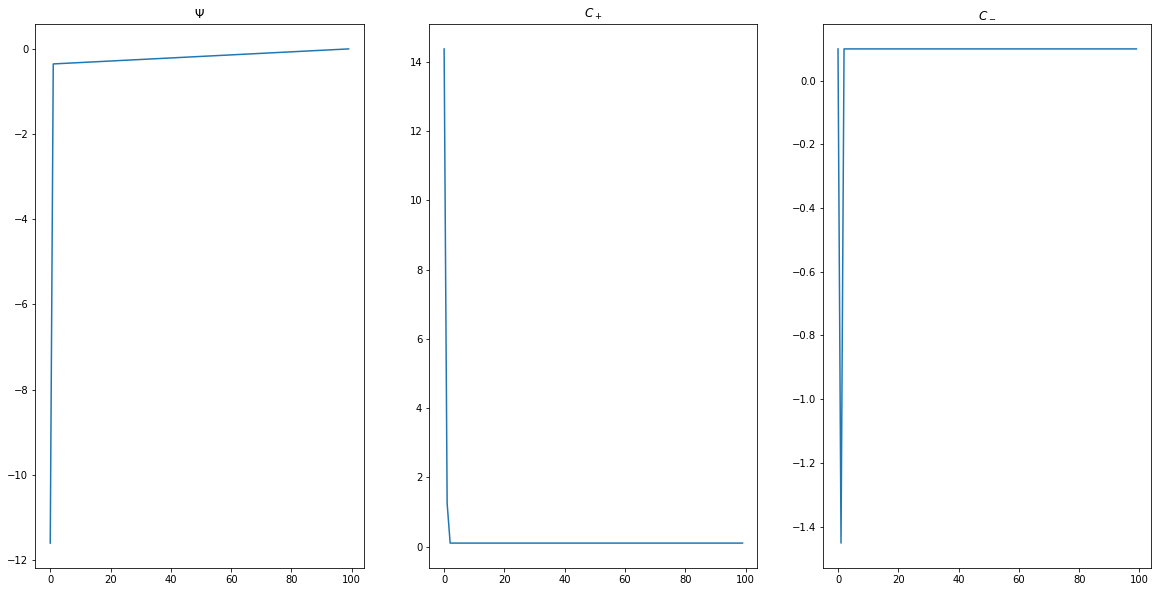

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in add
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in subtract
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_laun

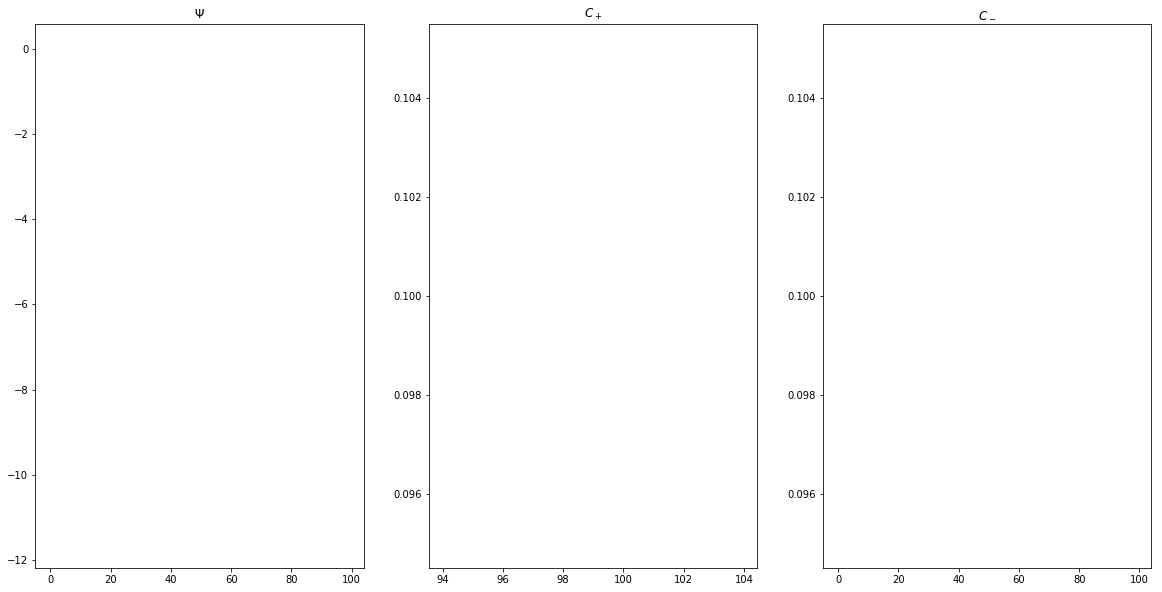

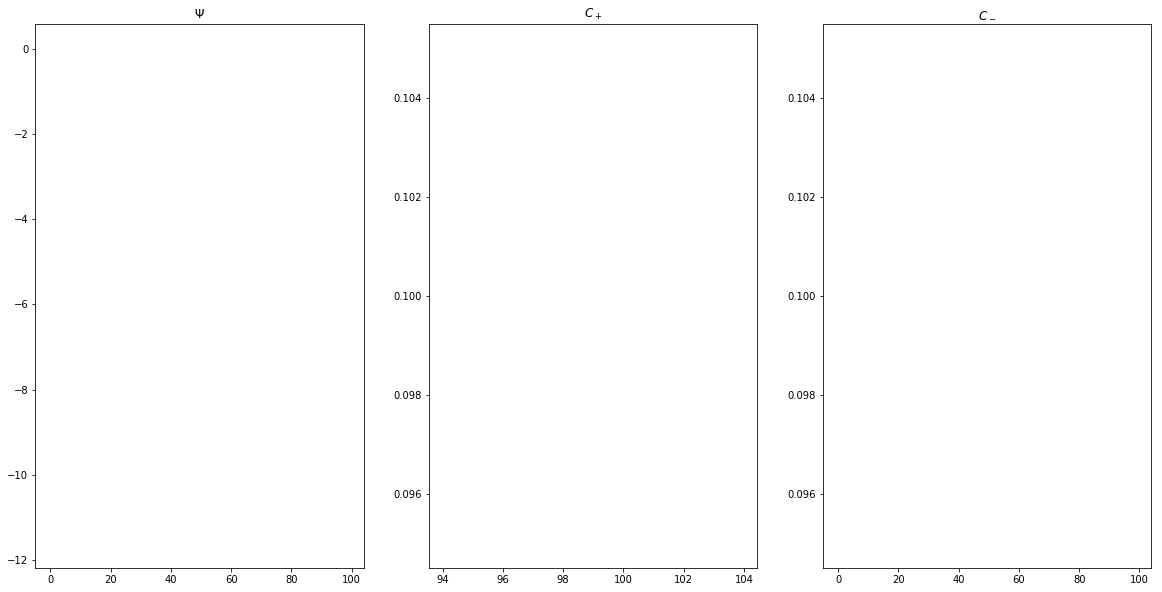

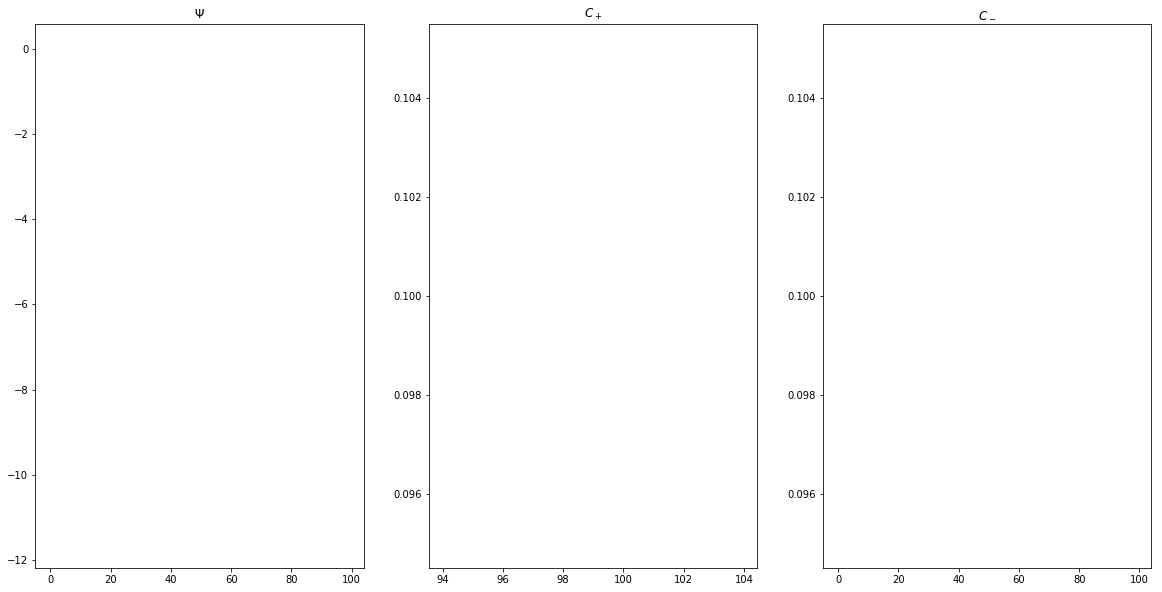

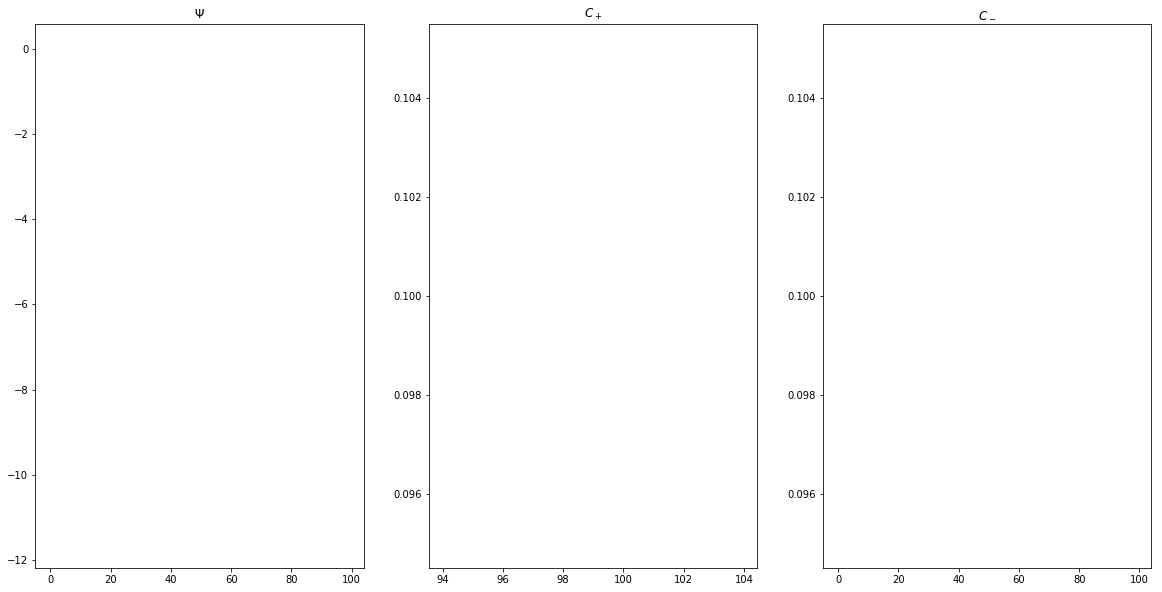

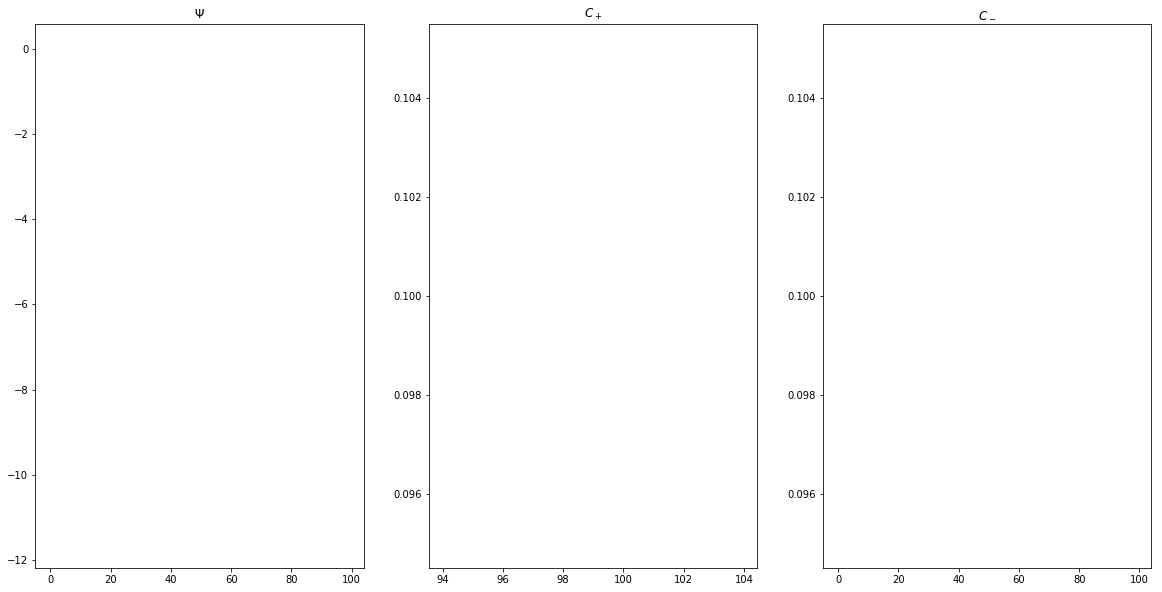

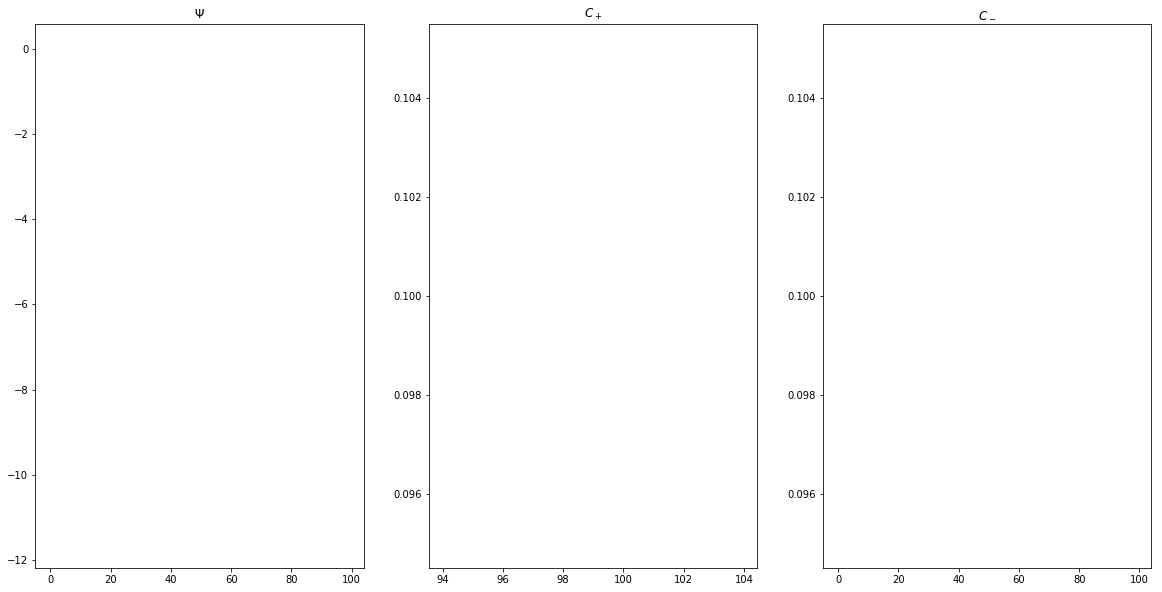

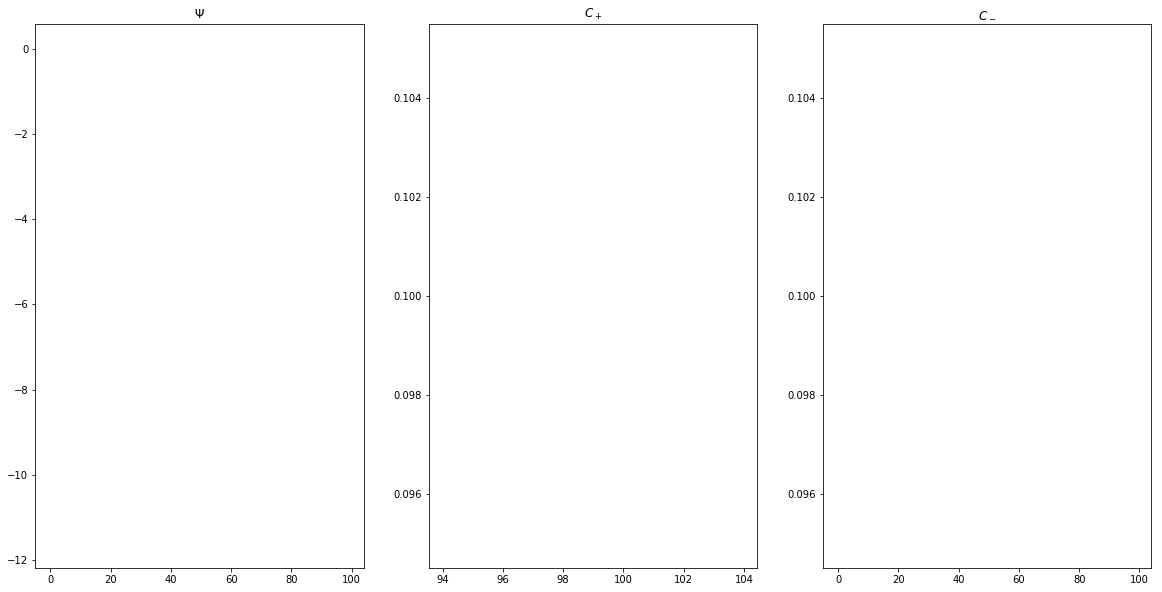

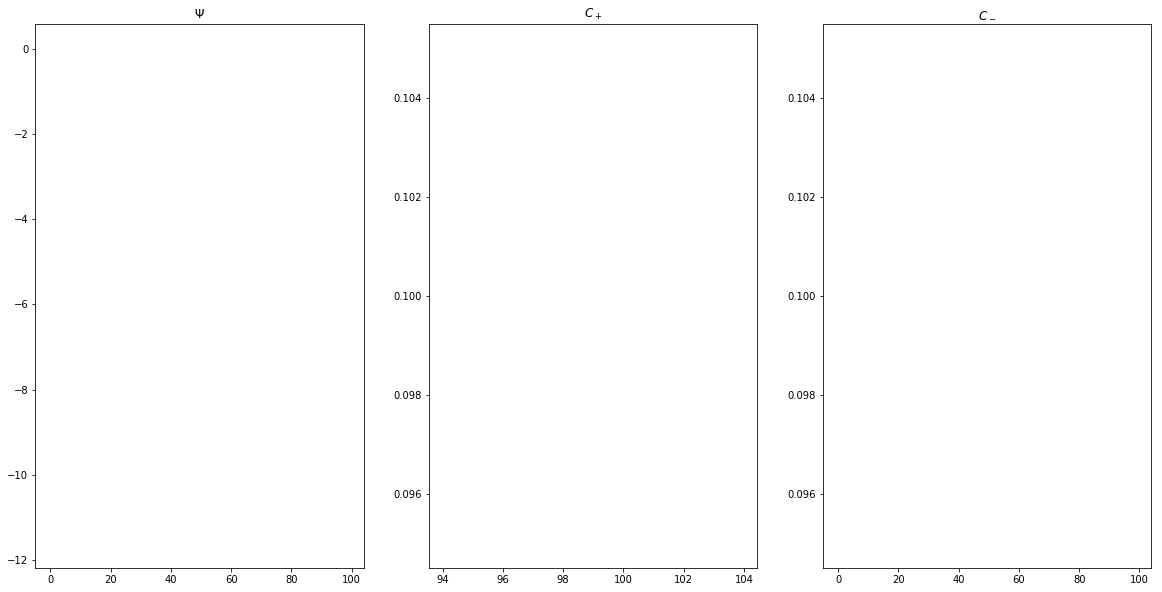

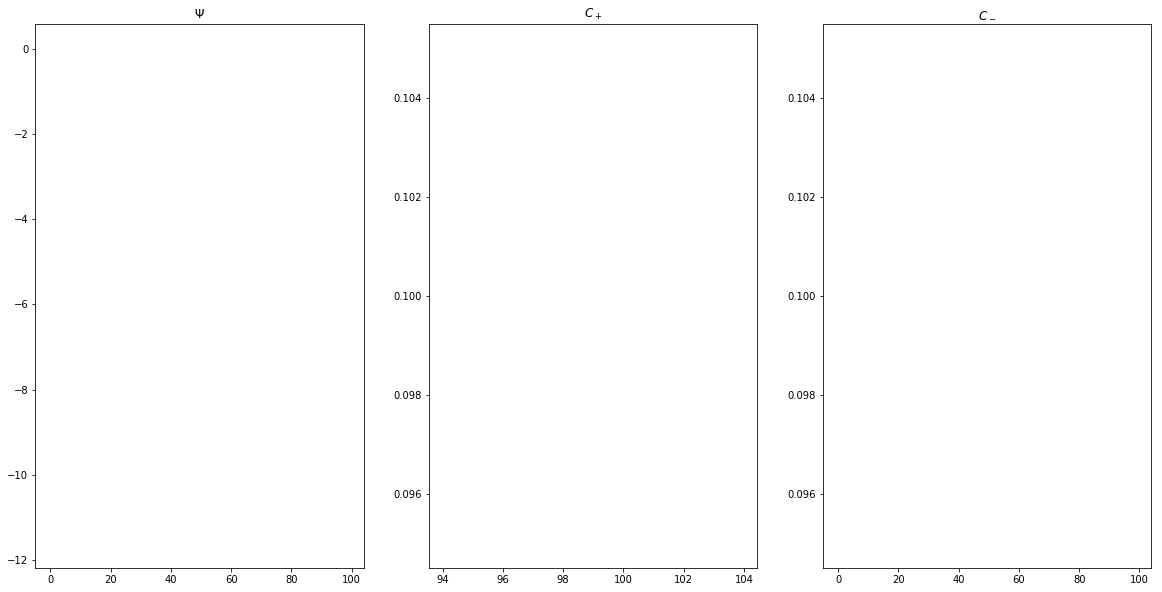

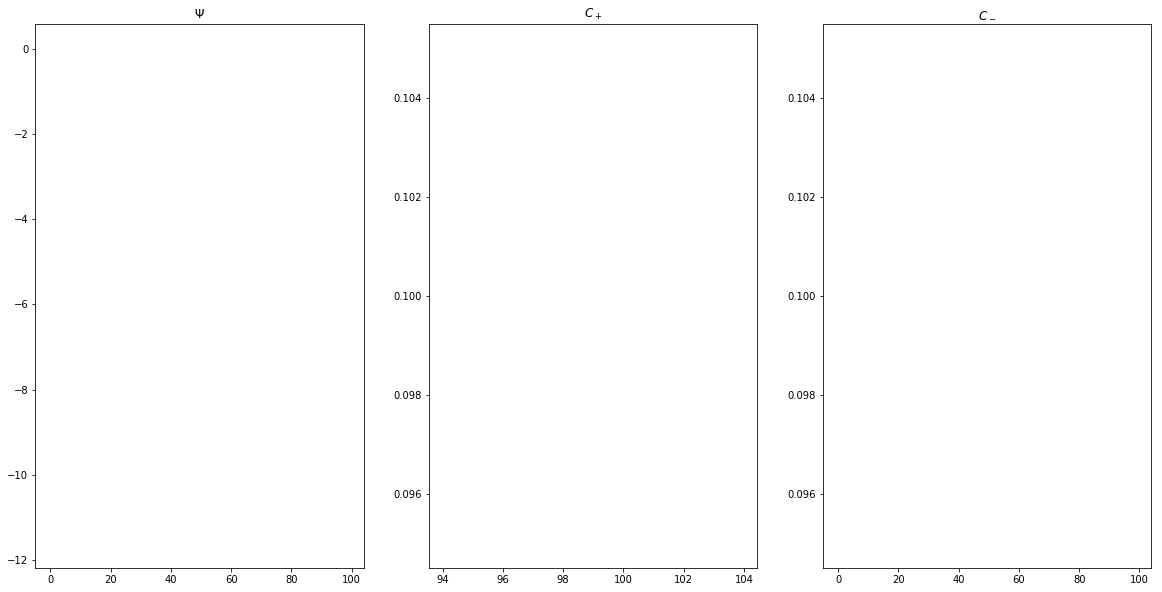

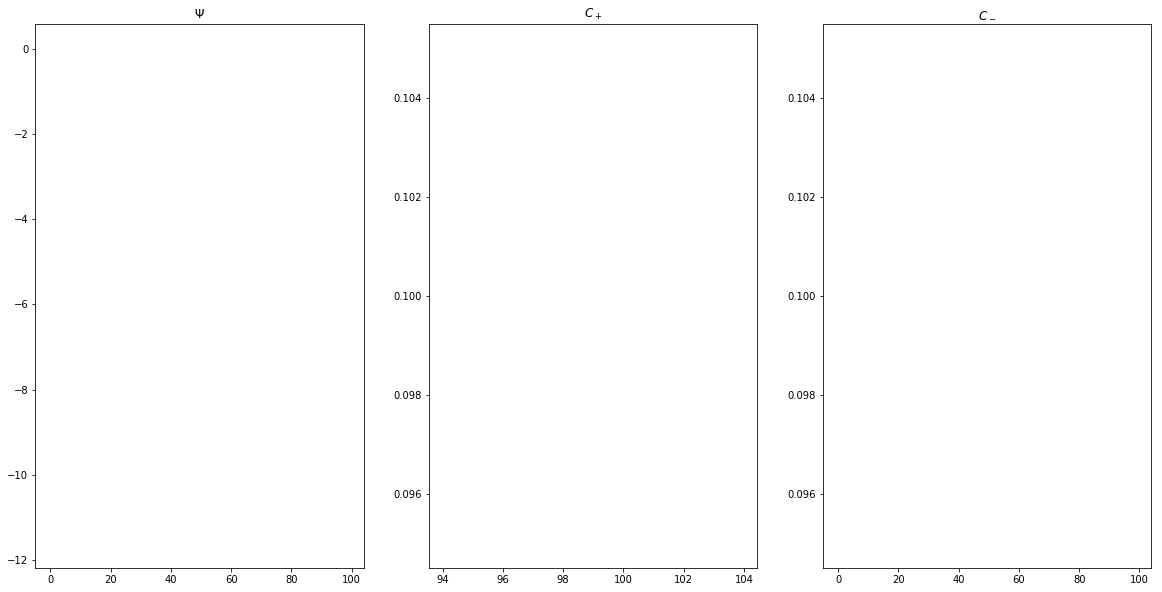

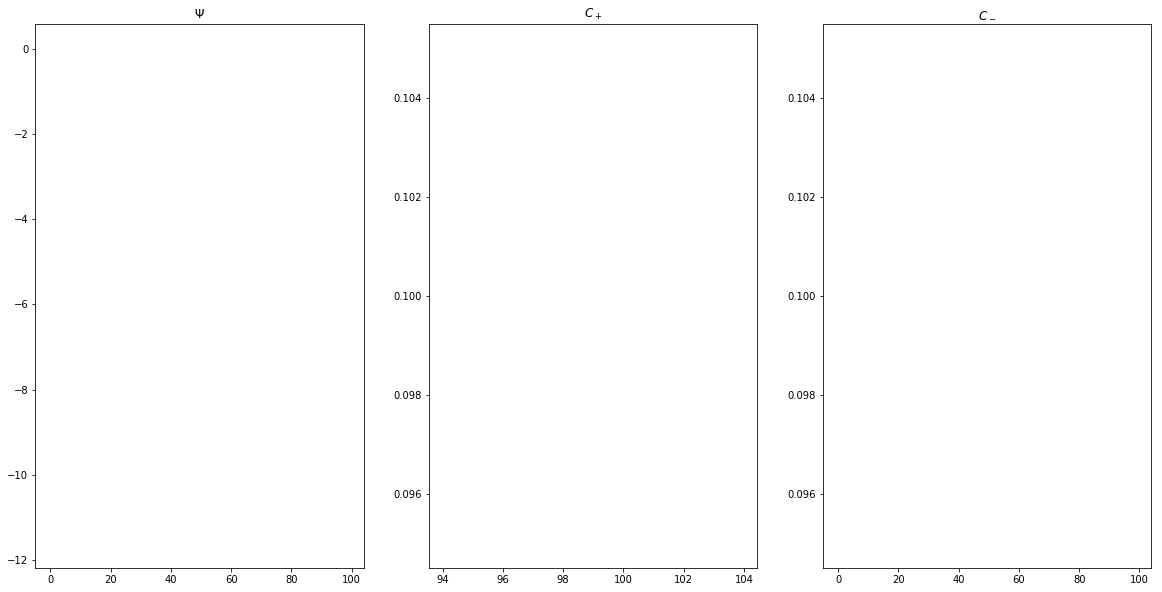

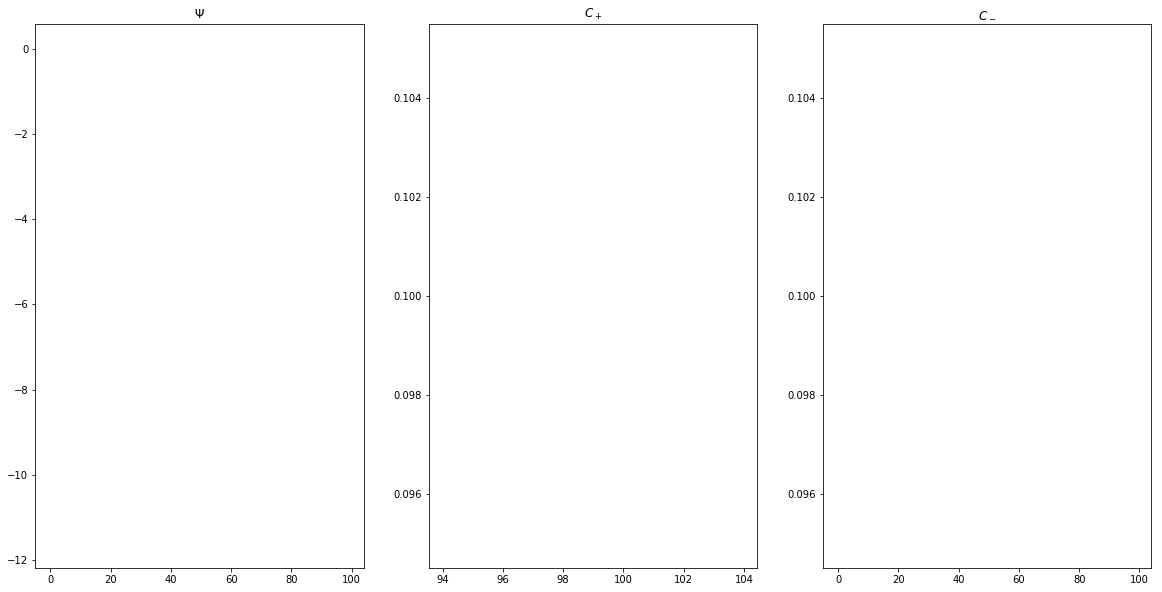

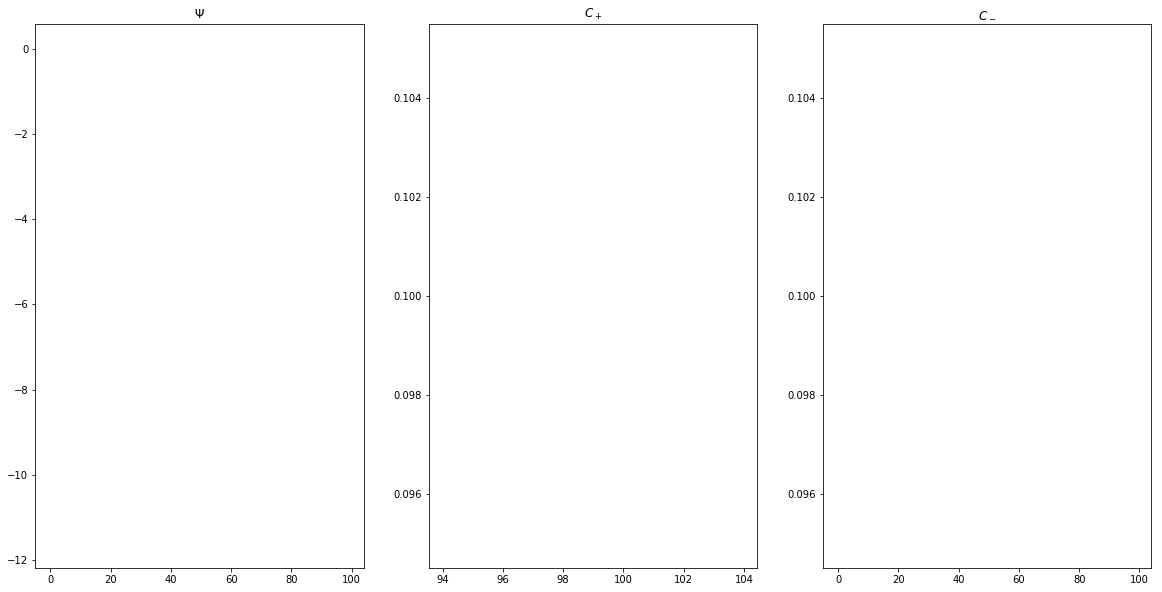

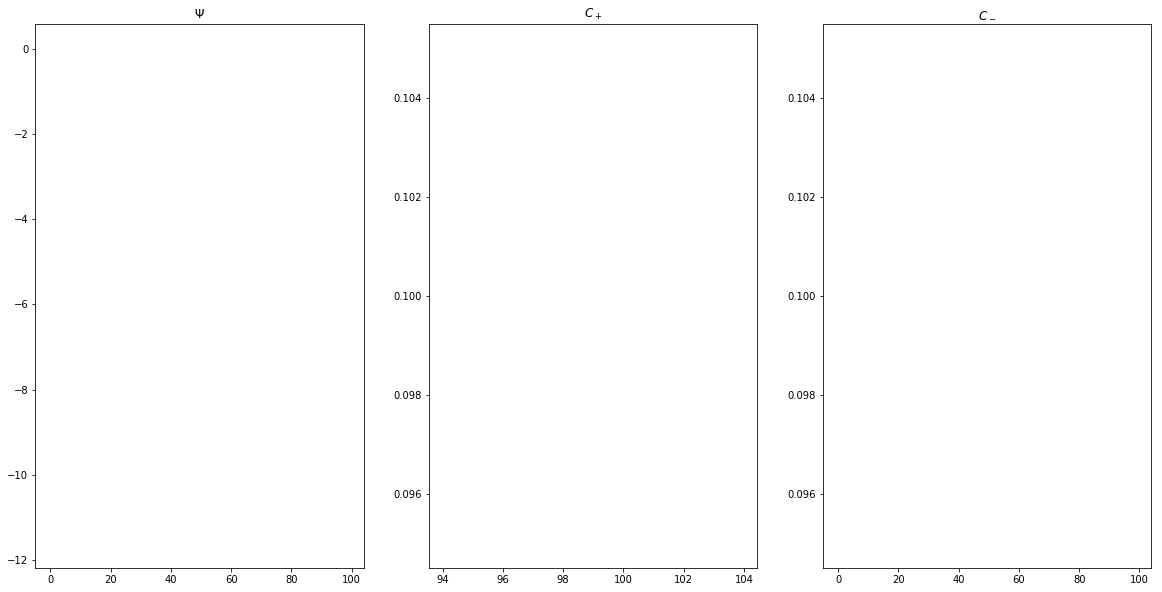

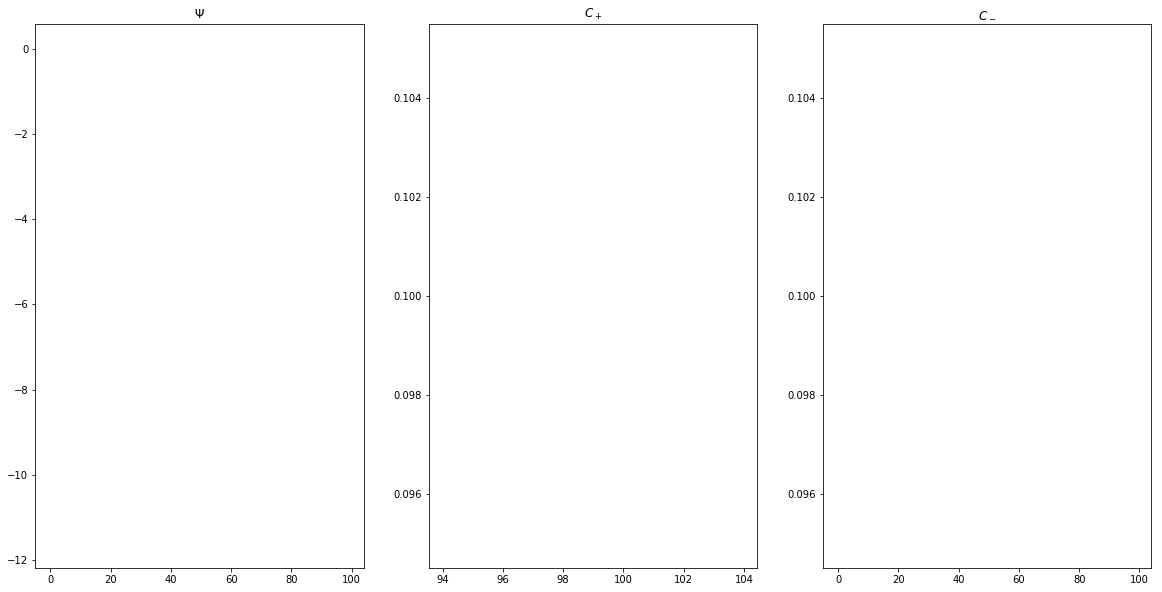

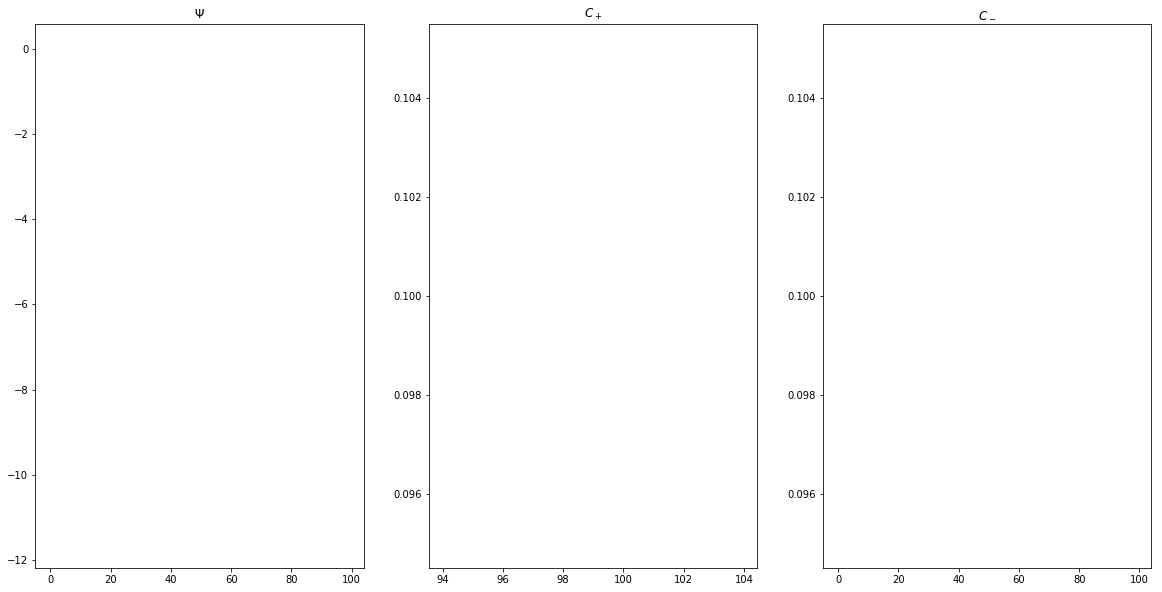

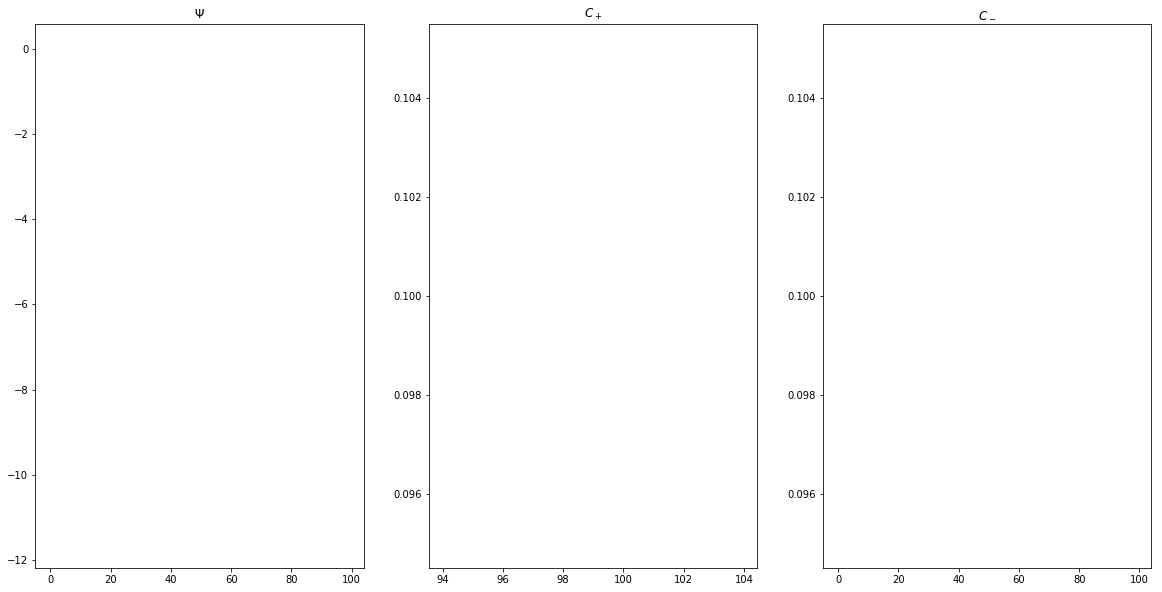

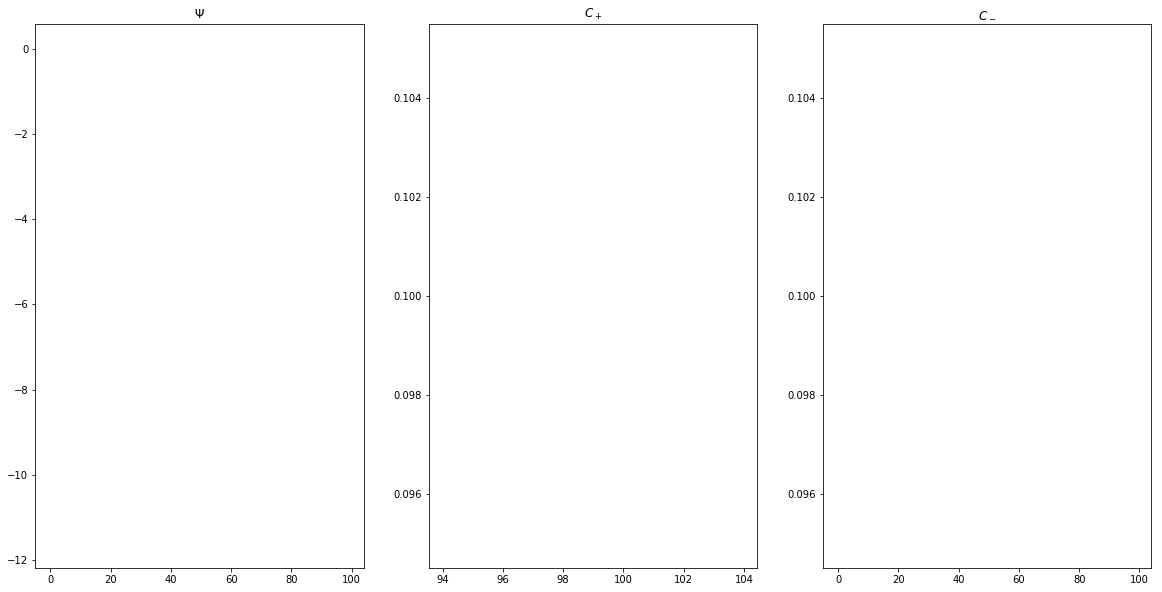

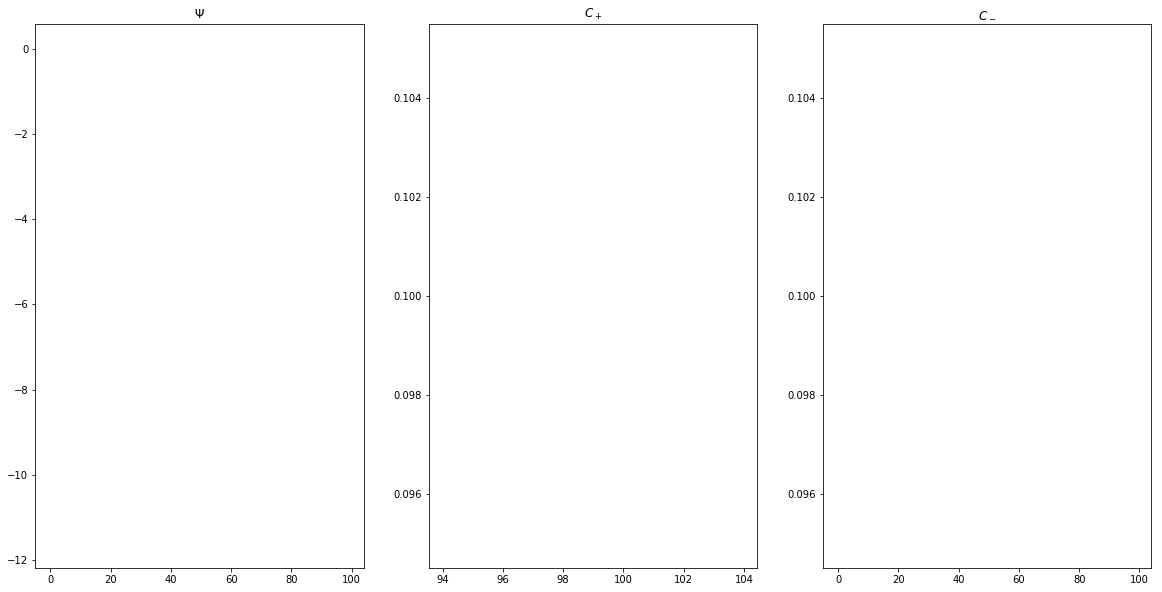

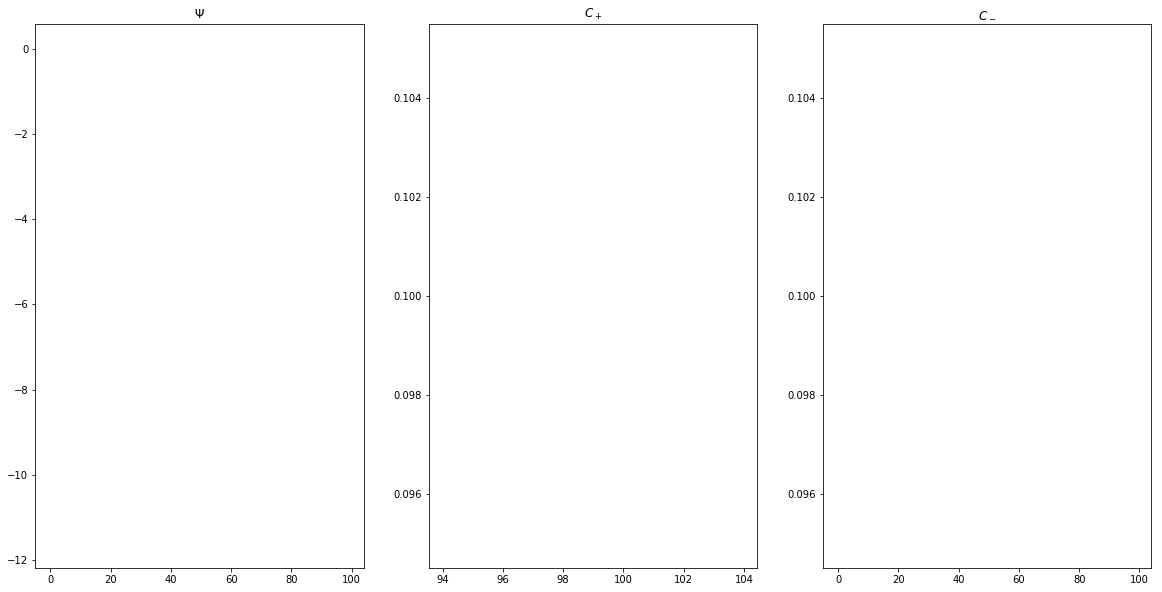

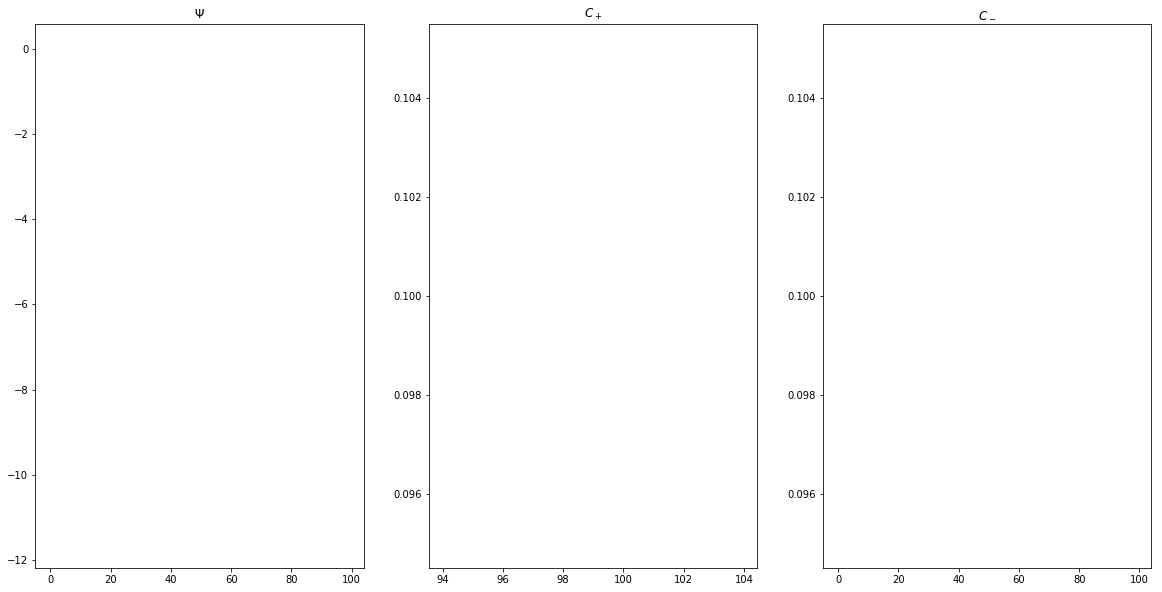

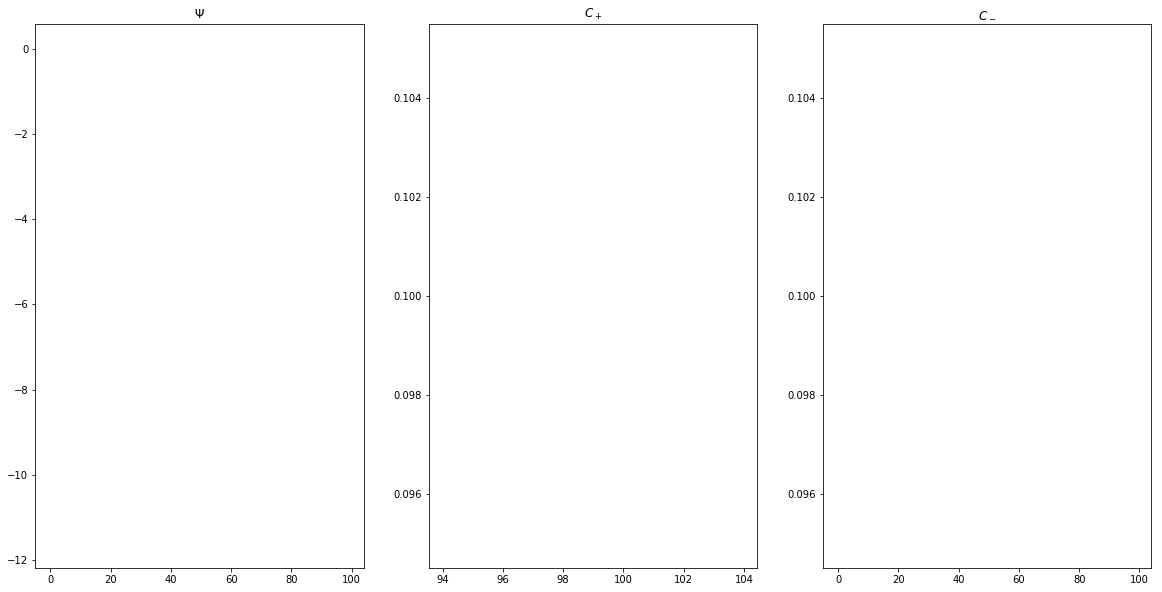

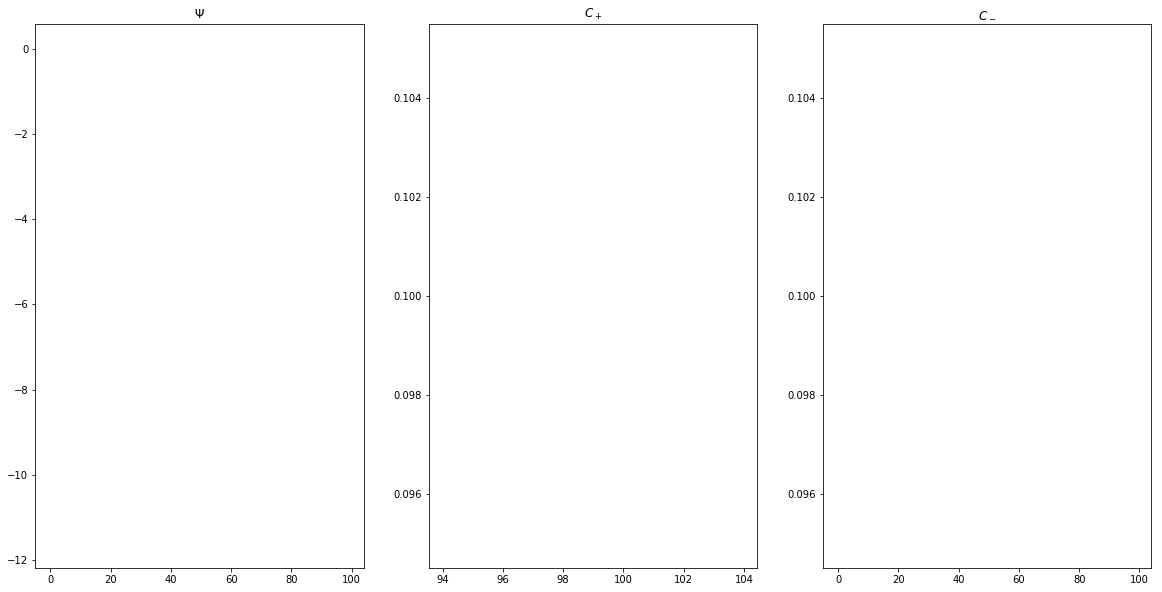

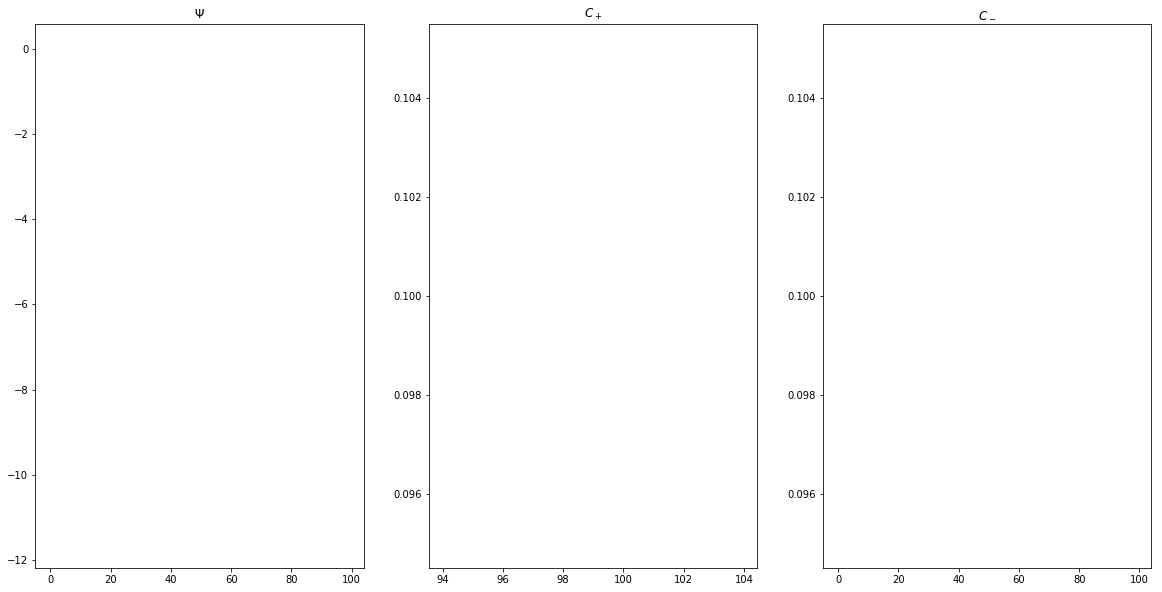

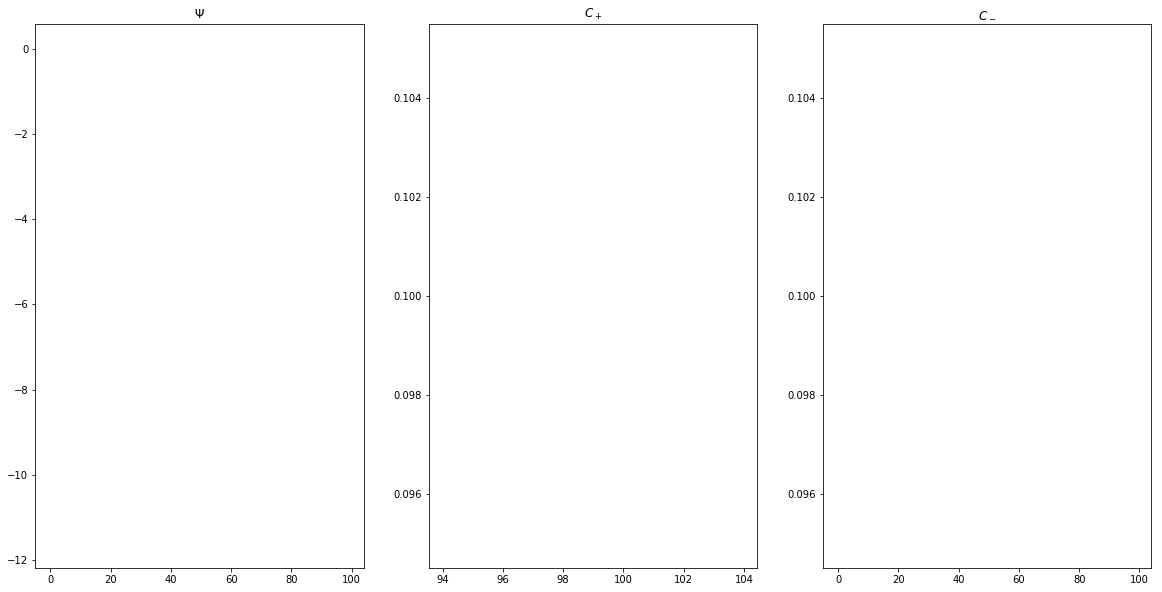

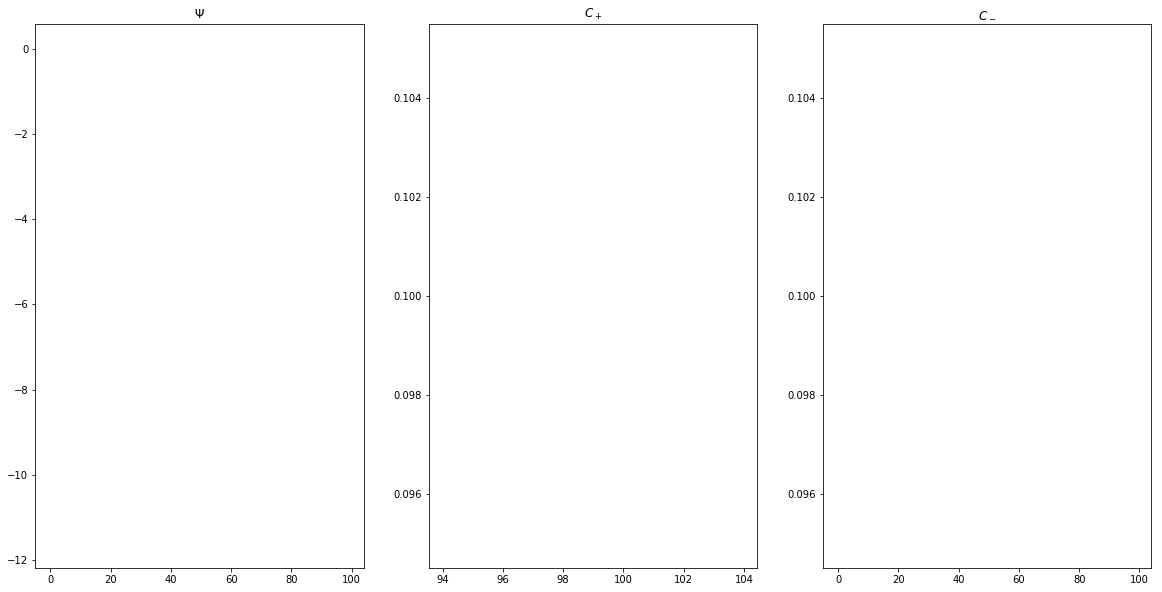

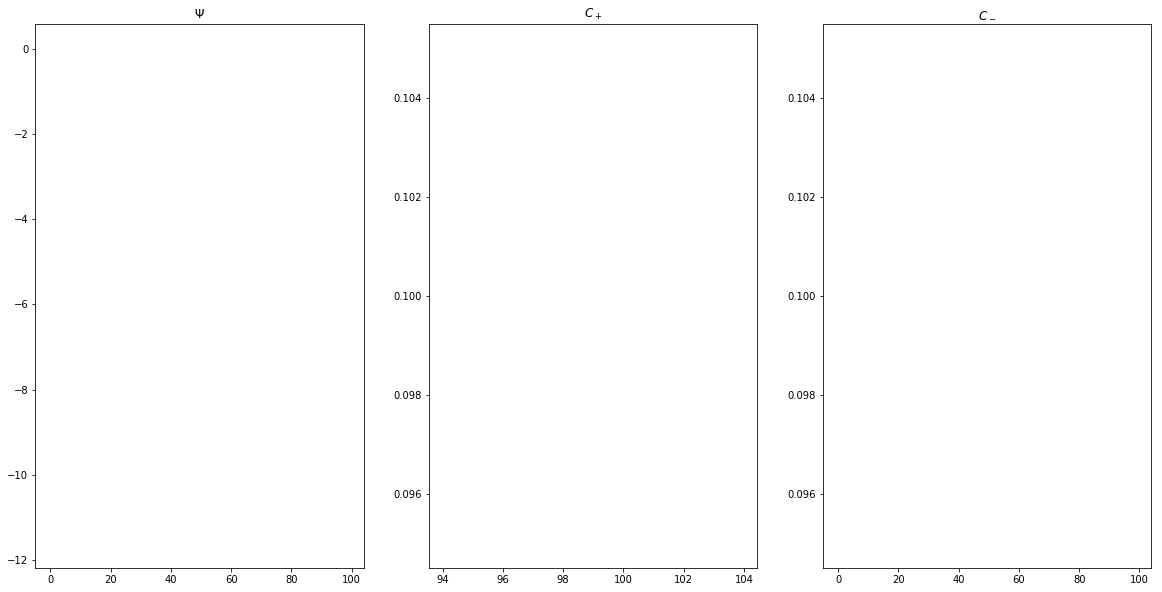

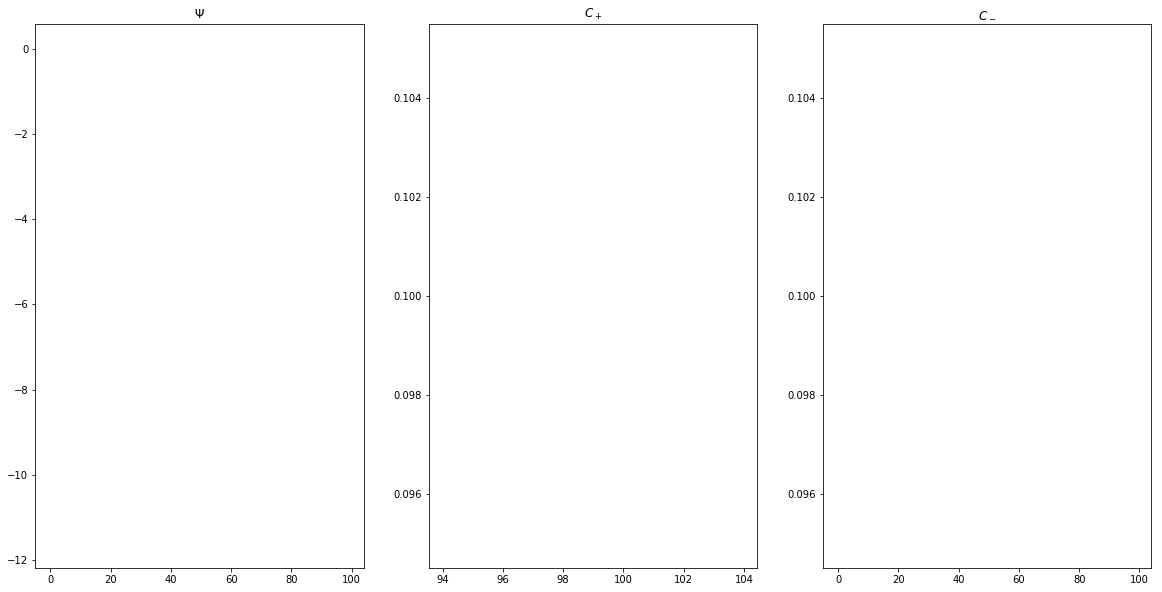

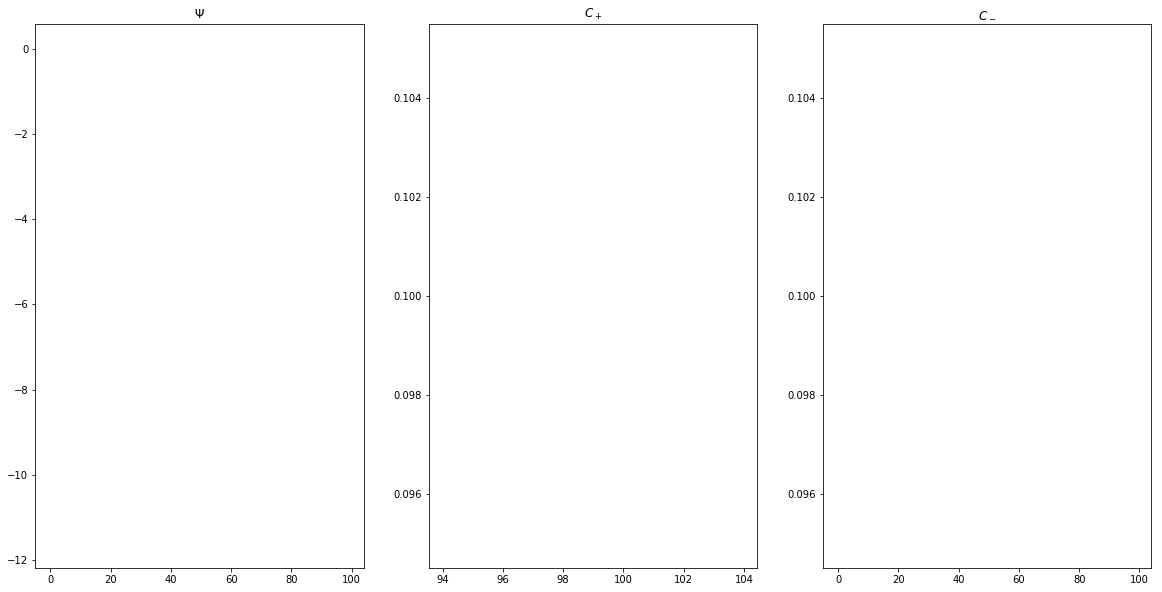

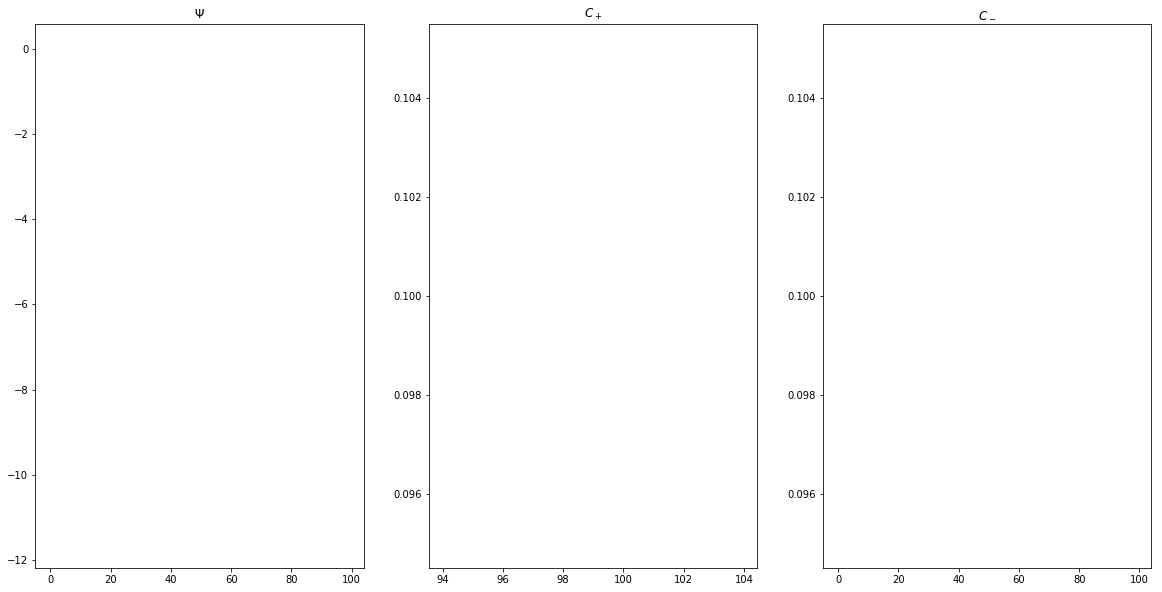

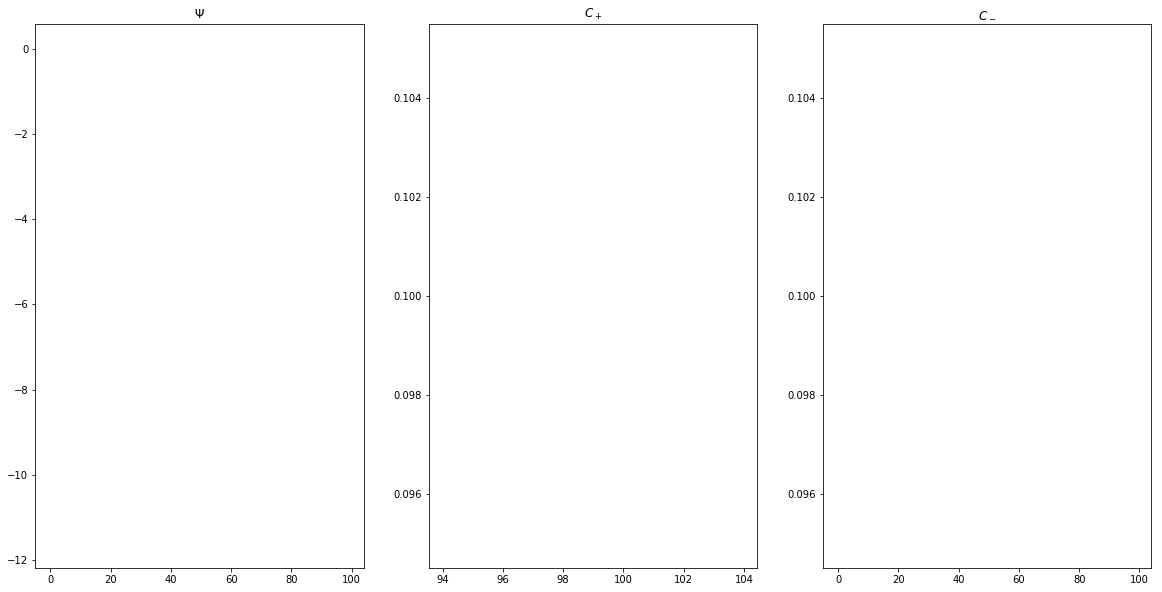

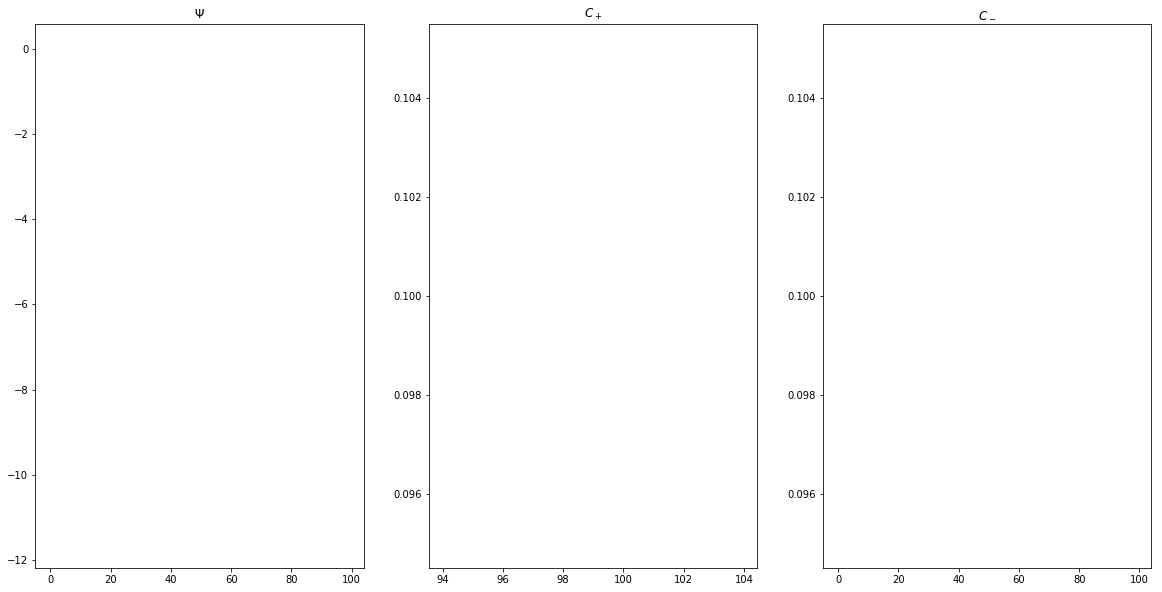

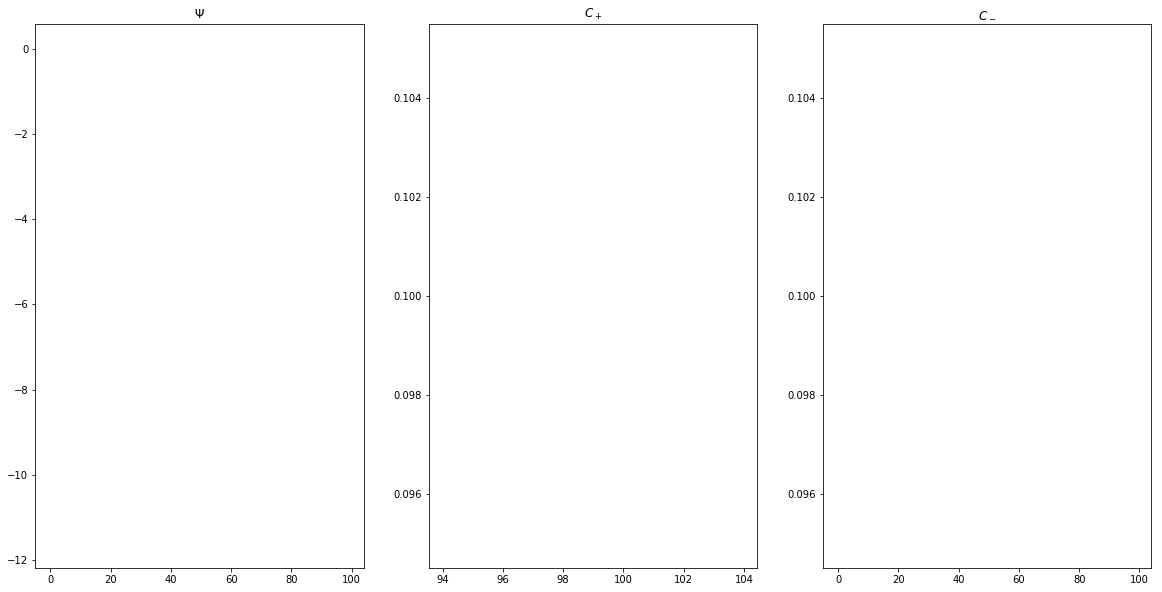

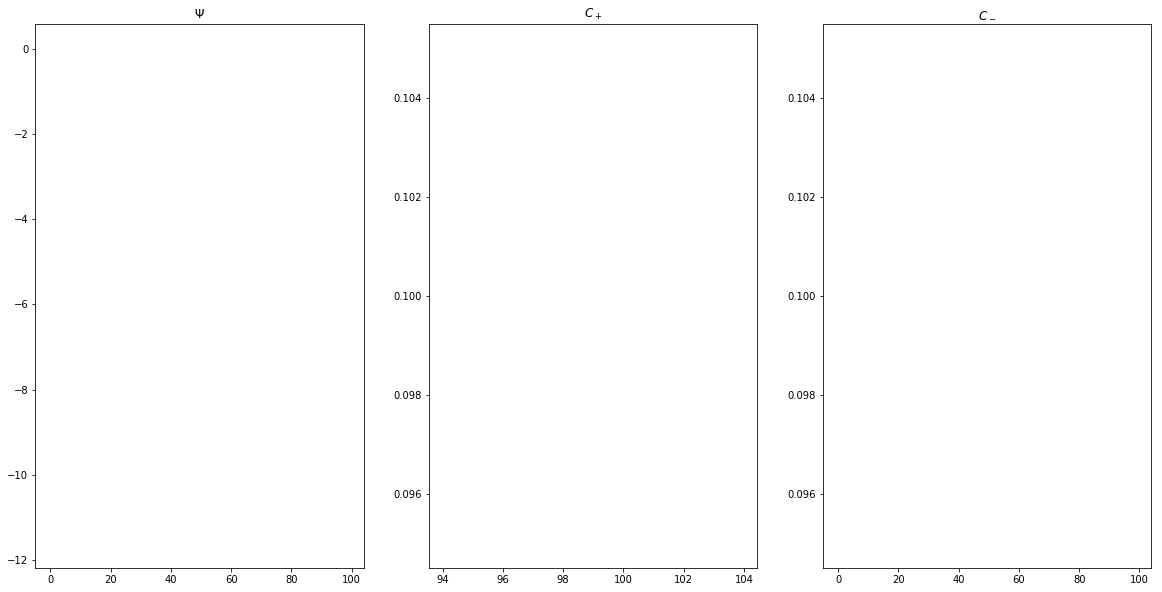

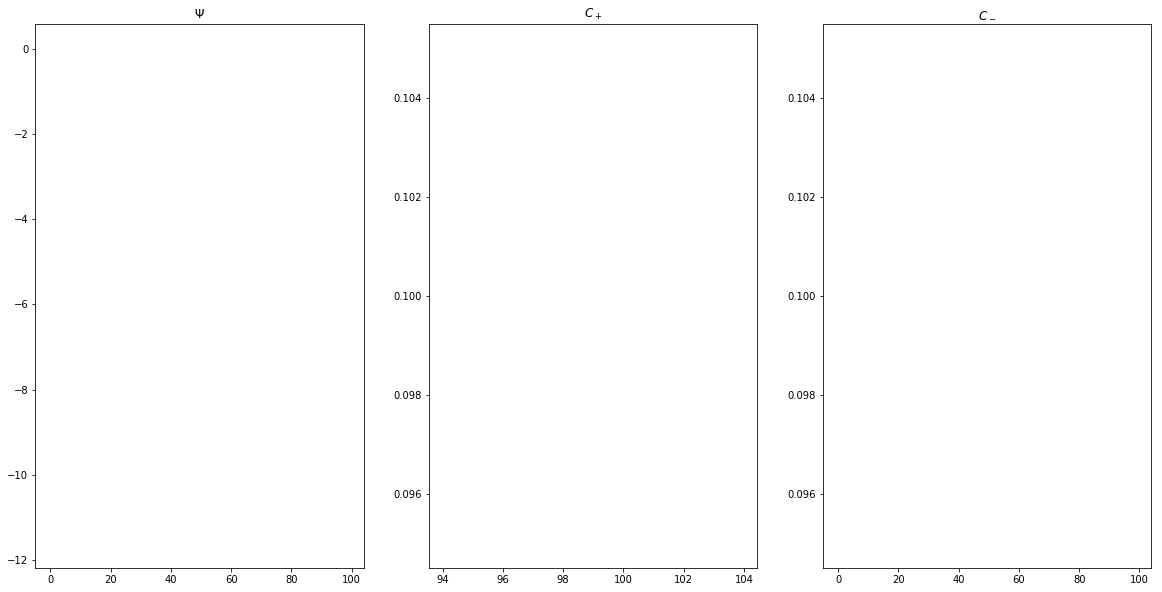

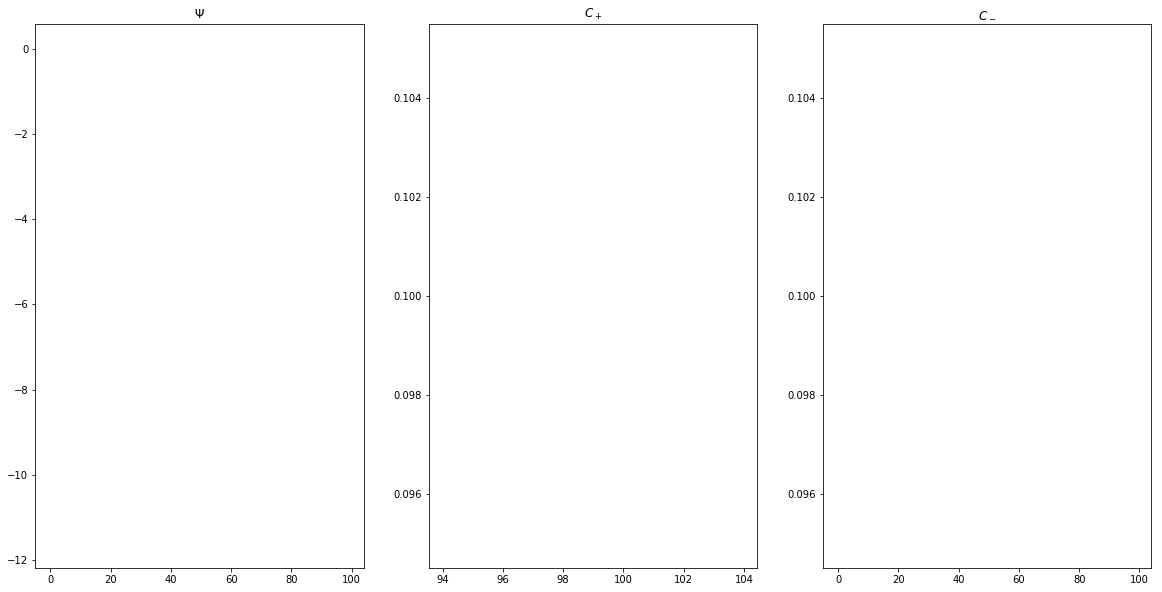

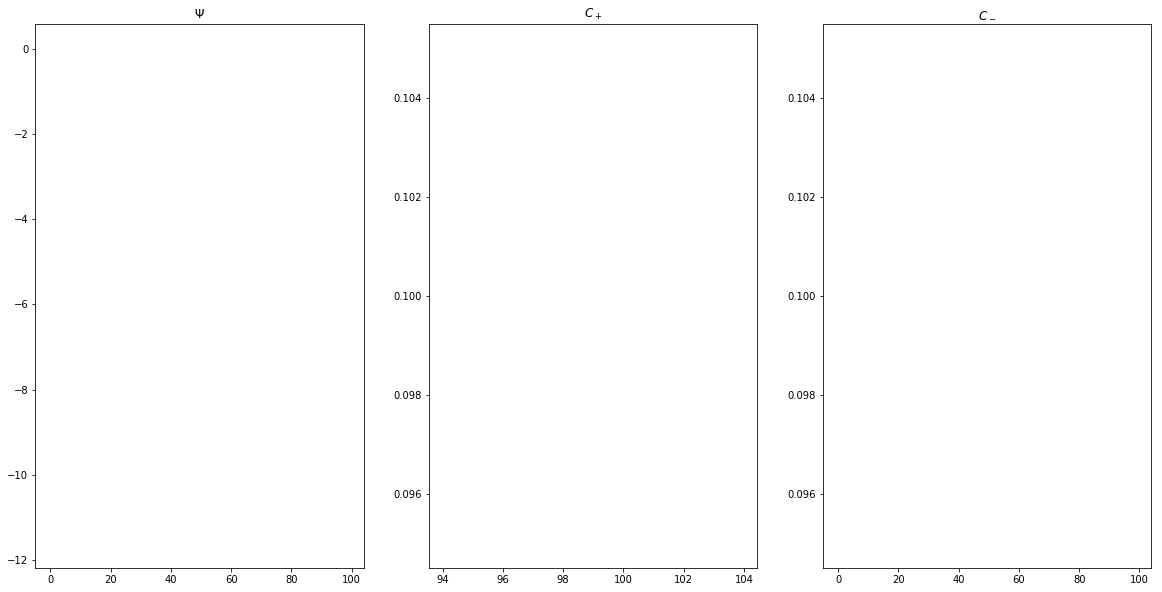

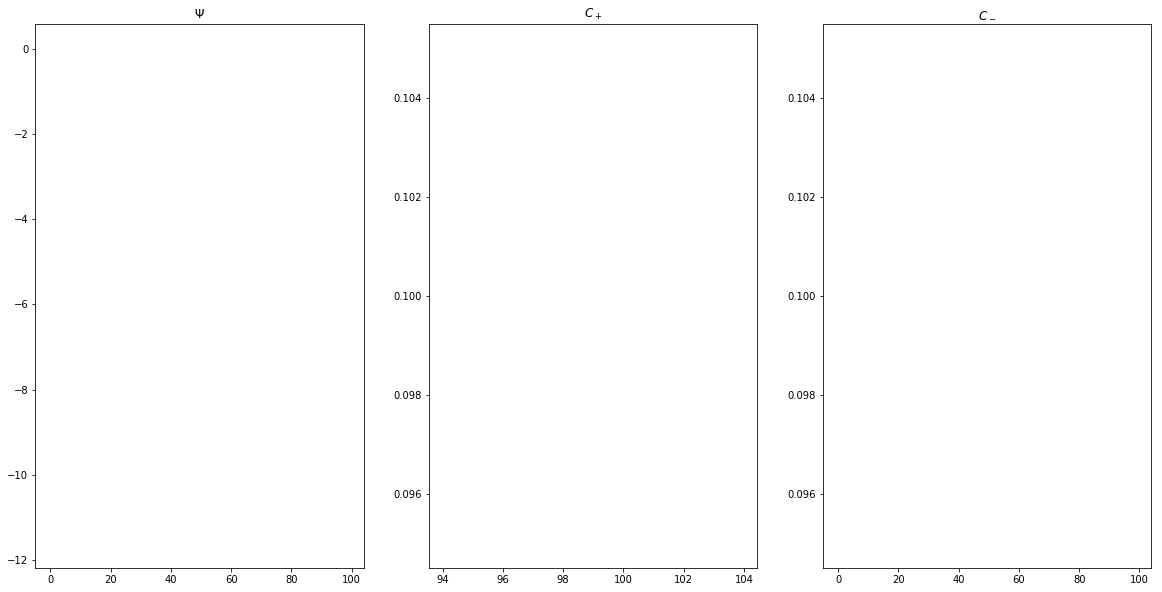

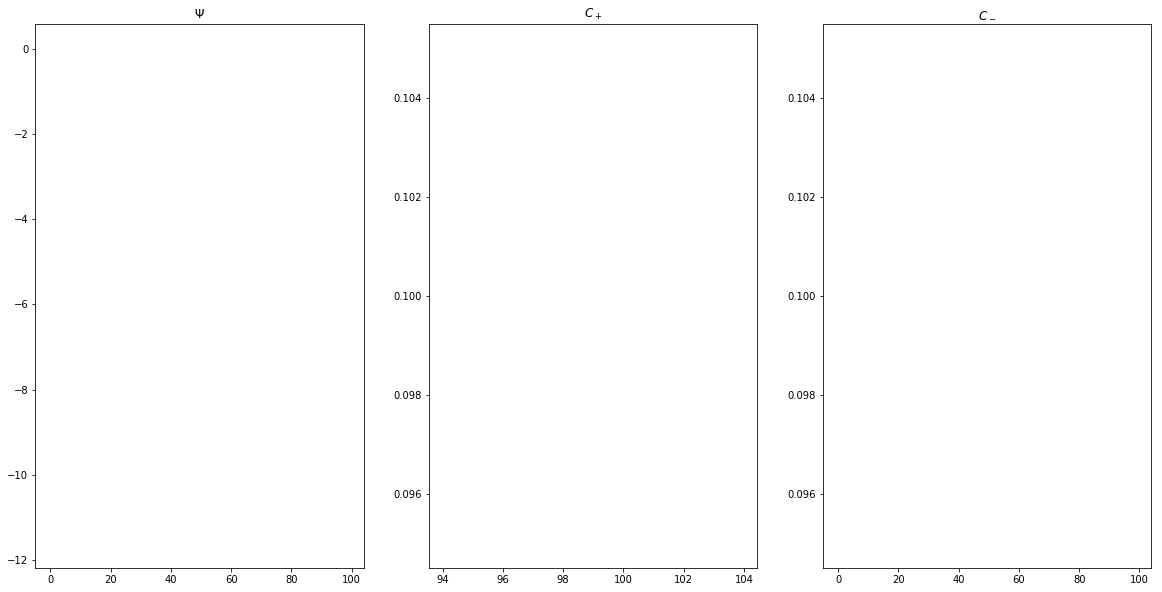

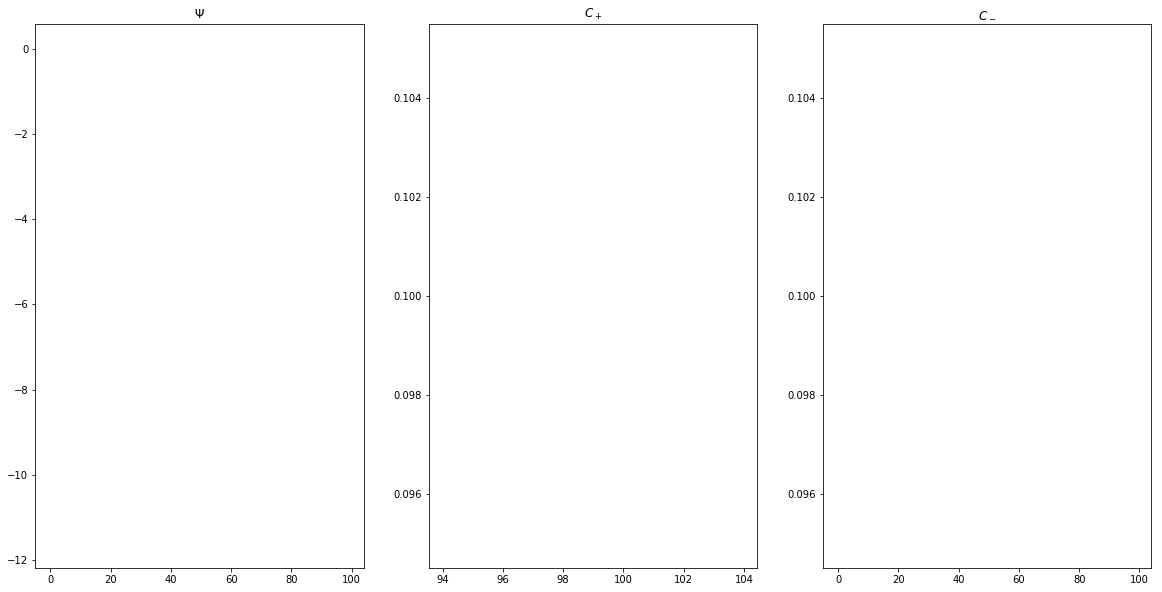

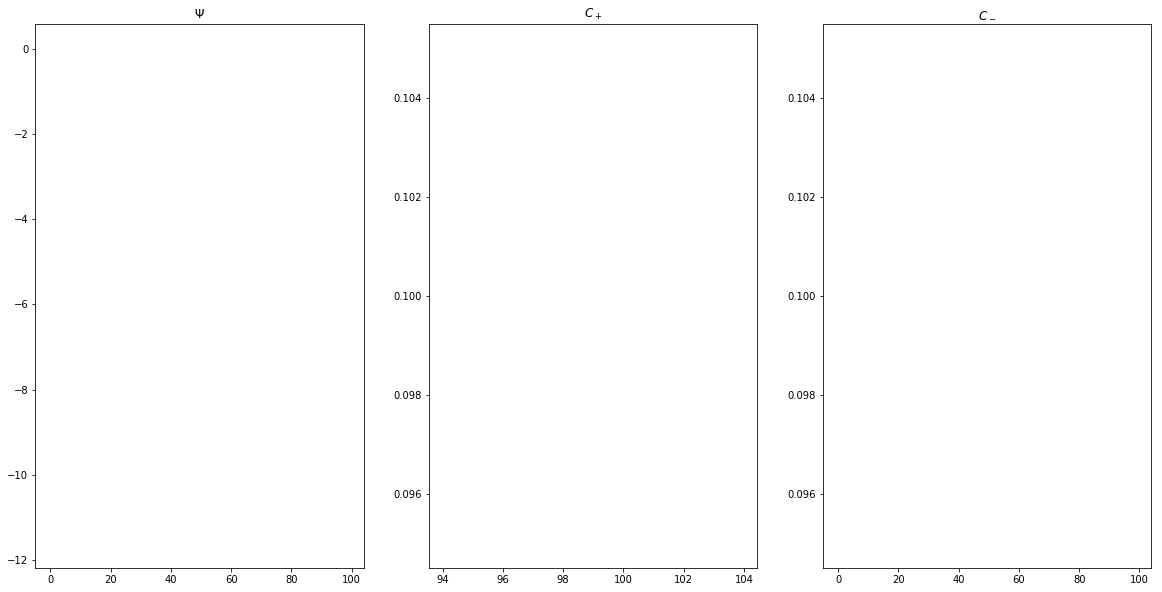

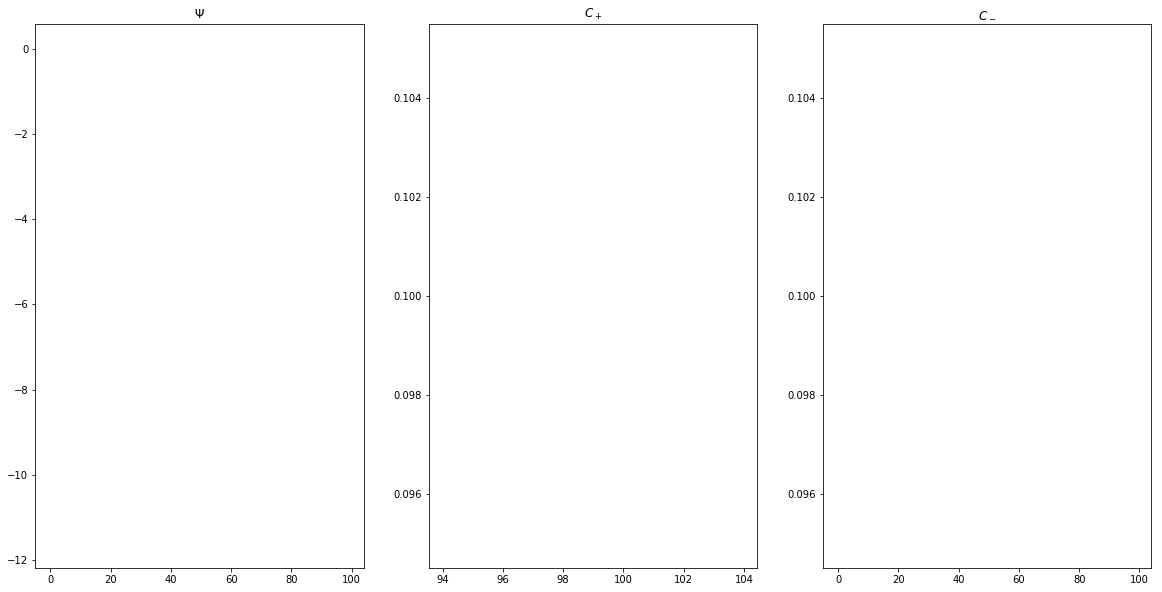

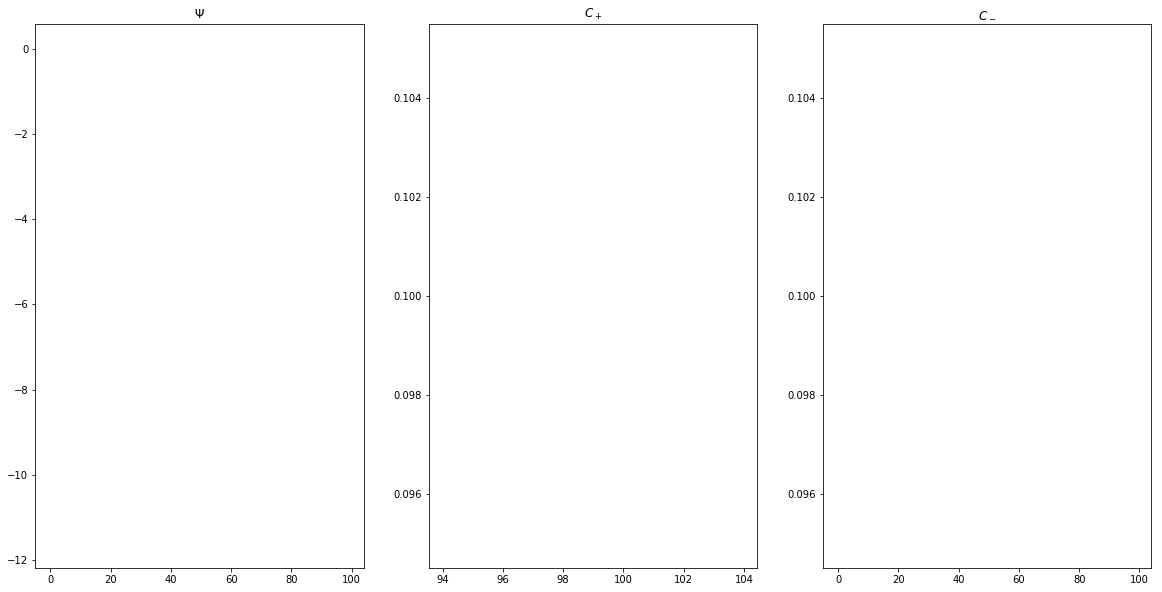

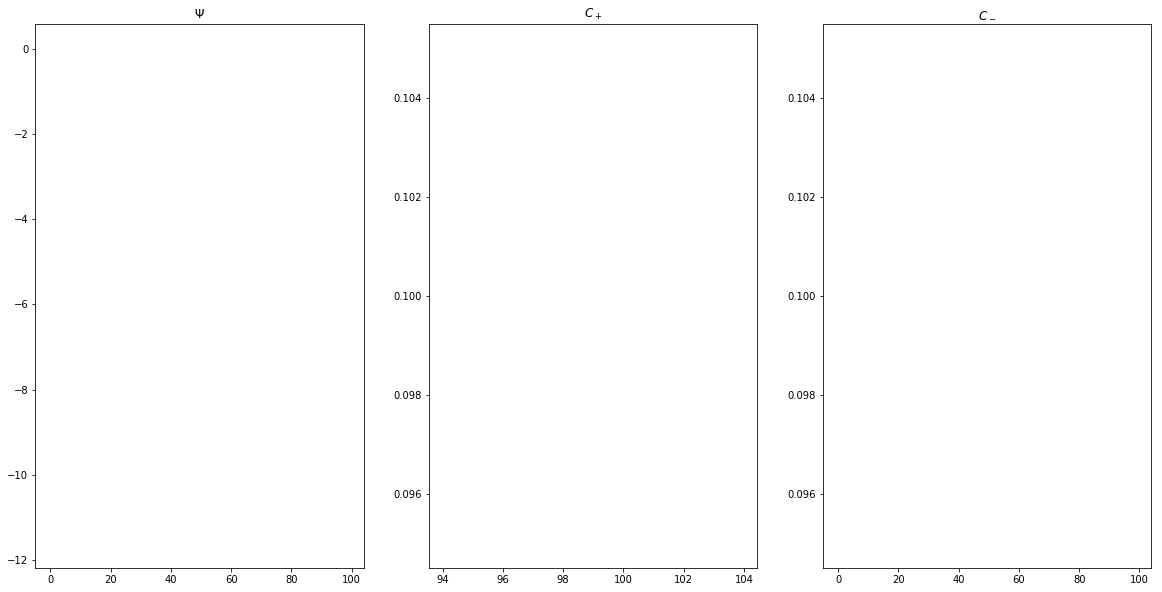

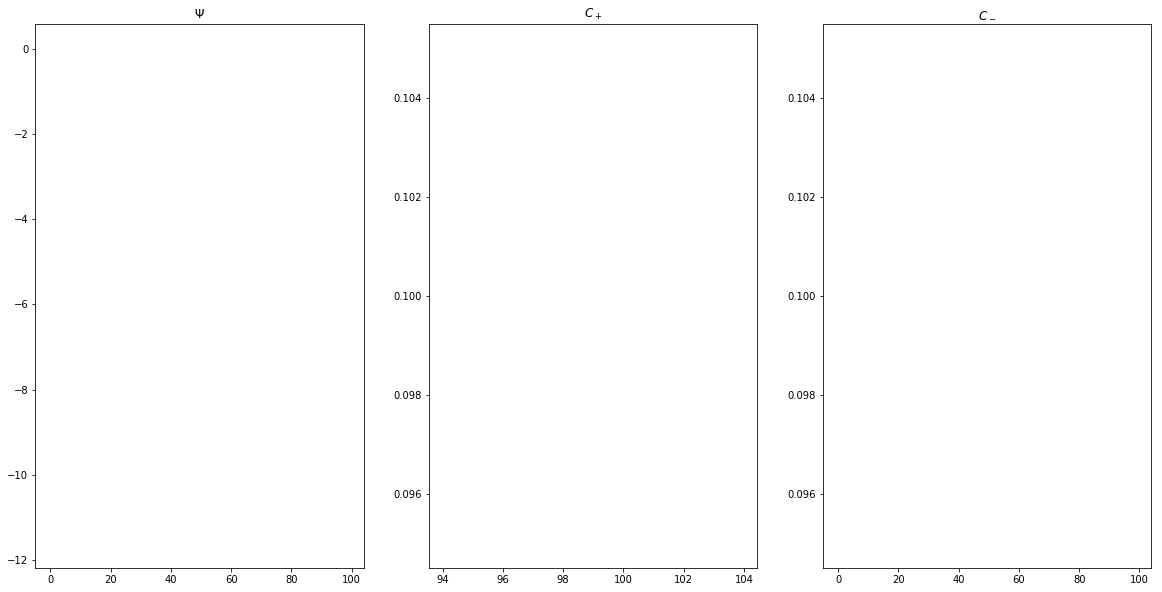

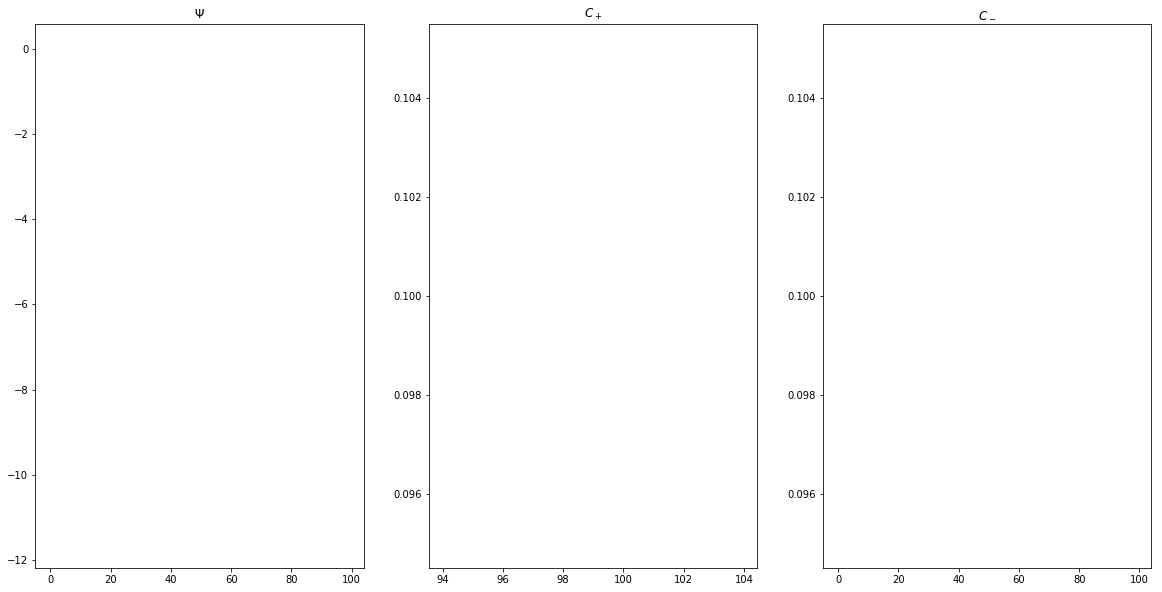

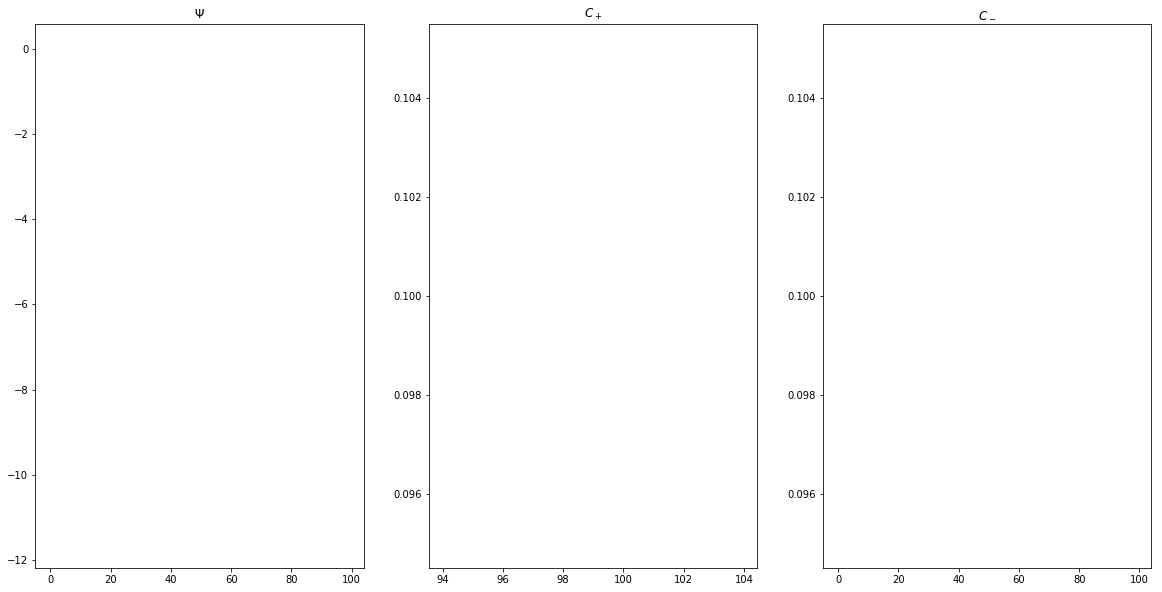

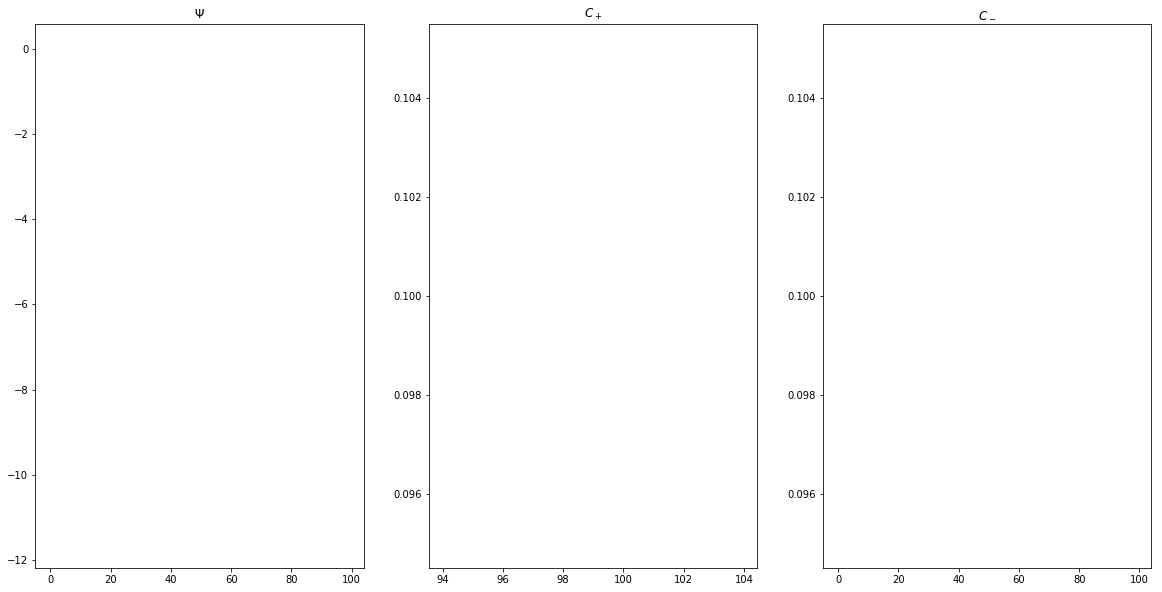

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100% 
done...


In [7]:
# We simulate the PDE with the finite difference
# method.
Psi_store_state = []
Cp_store_state = []
Cm_store_state = []
print("Initiating simulation")

plot_step = 100

for i in range(N):
    # We compute the Laplacian Cp, Cm and Psi
    deltaCp = d2(Cp)
    deltaCm = d2(Cm)
    deltaPsi = d2(Psi)
    # We compute the first derivative of Cp, Cm and Psi
    dPsi = d(Psi)
    dCm = d(Cm)
    dCp = d(Cp)
    dPsi[-1] = 0
    dCp[-1] = 0
    dCm[-1] = 0
    
    # We take the values of Cp, Cm and Psi inside the grid (current values).
    Cp_c = Cp[1:-1]
    Cm_c = Cm[1:-1]
    Psi_c = Psi[1:-1]
    
    
    
    # We update the variables for next time iteration (concentration).
    #Cp[1:-1] = Cp_c + dt * (D / dx ** 2) * (deltaCp - dCp * dPsi - Cp_c * (Cp_c - Cm_c)) 
    #Cm[1:-1] = Cm_c + dt * (D / dx ** 2) * (deltaCm + dCm * dPsi + Cm_c * (Cp_c - Cm_c))
    Cp[1:-1] = Cp_c + (dt * Dp / dx ** 2) * (deltaCp - dCp * dPsi - Cp_c * deltaPsi) 
    Cm[1:-1] = Cm_c + (dt * Dm / dx ** 2) * (deltaCm + dCm * dPsi + Cm_c * deltaPsi)
    
    Cp[0] = Cp[0] + (dt * Dp / dx ** 2) * (deltaCp[0] - dCp[0] * dPsi[0] - Cp_c[0] * deltaPsi[0]) 
    Cm[0] = Cm[0] #+ (dt * Dm / dx ** 2) * (deltaCm[0] + dCm[0] * dPsi[0] + Cm_c[0] * deltaPsi[0])
    
    #Compute next psi
    b[1:-1] = Cp[1:-1]-Cm[1:-1]
    b[1] = b[1] + V_0
    b[-1] = 0 
    Psi[1:-1] = -dx ** 2 * Ainv.dot(b[1:-1])   
    
    if(i%plot_step == 0):
        f()


    printProgressBar(i, N-2)

print('done...')

In [8]:

#from __future__ import print_function
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
#import matplotlib.pyplot as plt

#def f(t):
#    plt.figure(figsize=(20,10))
#    plt.subplot(1, 3, 1)
#    plt.title('$\Psi$')
#    plt.plot(Psi_store_state[t])
#    plt.subplot(1, 3, 2)
#    plt.title('$C_+$')
#    plt.plot(Cm_store_state[t])
#    plt.subplot(1, 3, 3)
#    plt.title('$C_-$')
#    plt.plot(Cp_store_state[t])
#    plt.show()

#interact(f, t=widgets.IntSlider(min=0,max=N-1,step=1,value=0));